# Energy Consumption Prediction Analysis

This notebook predicts energy consumption based on temperature pattern dataset.

# Import Libraries and Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from scipy import stats
from scipy.stats import jarque_bera, normaltest, shapiro
from statsmodels.stats.diagnostic import het_white
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import durbin_watson
import joblib
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Load and Initial Data Exploration

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url)
df.columns = ['Date', 'Temperature']
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

np.random.seed(42)
n_samples = len(df)
df['Temperature_C'] = df['Temperature']
df['Humidity'] = np.random.normal(65, 15, n_samples).clip(30, 95)
df['Wind_Speed'] = np.random.exponential(2, n_samples).clip(0, 15)
df['Solar_Radiation'] = np.random.gamma(2, 100, n_samples).clip(0, 800)
df['Pressure'] = np.random.normal(1013, 10, n_samples).clip(990, 1030)

base_consumption = 1000
temp_effect = np.where(df['Temperature_C'] < 10, (10 - df['Temperature_C']) * 50, 0) + \
              np.where(df['Temperature_C'] > 25, (df['Temperature_C'] - 25) * 30, 0)
humidity_effect = (df['Humidity'] - 50) * 5
wind_effect = -df['Wind_Speed'] * 10
solar_effect = -df['Solar_Radiation'] * 0.5
pressure_effect = (df['Pressure'] - 1013) * 2

df['Energy_Consumption'] = (base_consumption + temp_effect + humidity_effect +
                           wind_effect + solar_effect + pressure_effect +
                           np.random.normal(0, 50, n_samples)).clip(200, 3000)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Missing values: {df.isnull().sum().sum()}")

Dataset shape: (3650, 7)
Date range: 1981-01-01 00:00:00 to 1990-12-31 00:00:00
Missing values: 0


# Statistical Summary

In [3]:
print("=== STATISTICAL SUMMARY ===")
print(df.describe())
print("\n=== DATA TYPES ===")
print(df.dtypes)
print("\n=== CORRELATION MATRIX ===")
correlation_matrix = df.corr()
print(correlation_matrix.round(3))

=== STATISTICAL SUMMARY ===
       Temperature  Temperature_C     Humidity   Wind_Speed  Solar_Radiation  \
count  3650.000000    3650.000000  3650.000000  3650.000000      3650.000000   
mean     11.177753      11.177753    65.295782     1.948622       199.423054   
std       4.071837       4.071837    14.507403     1.950444       140.094815   
min       0.000000       0.000000    30.000000     0.000454         2.224753   
25%       8.300000       8.300000    55.259763     0.557150        96.937294   
50%      11.000000      11.000000    65.328332     1.325376       166.379532   
75%      14.000000      14.000000    75.200923     2.700529       268.820587   
max      26.300000      26.300000    95.000000    15.000000       800.000000   

          Pressure  Energy_Consumption  
count  3650.000000         3650.000000  
mean   1013.008130         1013.825009  
std       9.557315          148.377453  
min     990.000000          483.715182  
25%    1006.222143          917.731686  
50%  

# Feature Engineering


In [4]:
df_features = df.copy()
df_features['Month'] = df_features.index.month
df_features['Day_of_Year'] = df_features.index.dayofyear
df_features['Quarter'] = df_features.index.quarter
df_features['Year'] = df_features.index.year
df_features['Week_of_Year'] = df_features.index.isocalendar().week
df_features['Day_of_Week'] = df_features.index.dayofweek
df_features['Is_Weekend'] = (df_features['Day_of_Week'] >= 5).astype(int)

df_features['Season'] = df_features['Month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                                 3: 'Spring', 4: 'Spring', 5: 'Spring',
                                                 6: 'Summer', 7: 'Summer', 8: 'Summer',
                                                 9: 'Autumn', 10: 'Autumn', 11: 'Autumn'})

df_features['Temp_Category'] = pd.cut(df_features['Temperature_C'],
                                     bins=[-np.inf, 5, 15, 25, np.inf],
                                     labels=['Cold', 'Cool', 'Moderate', 'Hot'])

df_features['Temp_Humidity_Interaction'] = df_features['Temperature_C'] * df_features['Humidity']
df_features['Wind_Solar_Interaction'] = df_features['Wind_Speed'] * df_features['Solar_Radiation']
df_features['Pressure_Temp_Interaction'] = df_features['Pressure'] * df_features['Temperature_C']

df_features['Temperature_Squared'] = df_features['Temperature_C'] ** 2
df_features['Humidity_Squared'] = df_features['Humidity'] ** 2
df_features['Wind_Speed_Sqrt'] = np.sqrt(df_features['Wind_Speed'])

df_features['Temp_MA_7'] = df_features['Temperature_C'].rolling(window=7, min_periods=1).mean()
df_features['Temp_MA_30'] = df_features['Temperature_C'].rolling(window=30, min_periods=1).mean()
df_features['Energy_MA_7'] = df_features['Energy_Consumption'].rolling(window=7, min_periods=1).mean()

df_features['Temp_Lag_1'] = df_features['Temperature_C'].shift(1)
df_features['Temp_Lag_7'] = df_features['Temperature_C'].shift(7)
df_features['Energy_Lag_1'] = df_features['Energy_Consumption'].shift(1)

print(f"Feature engineering completed. New shape: {df_features.shape}")

Feature engineering completed. New shape: (3650, 28)


# Data Visualization Dashboard


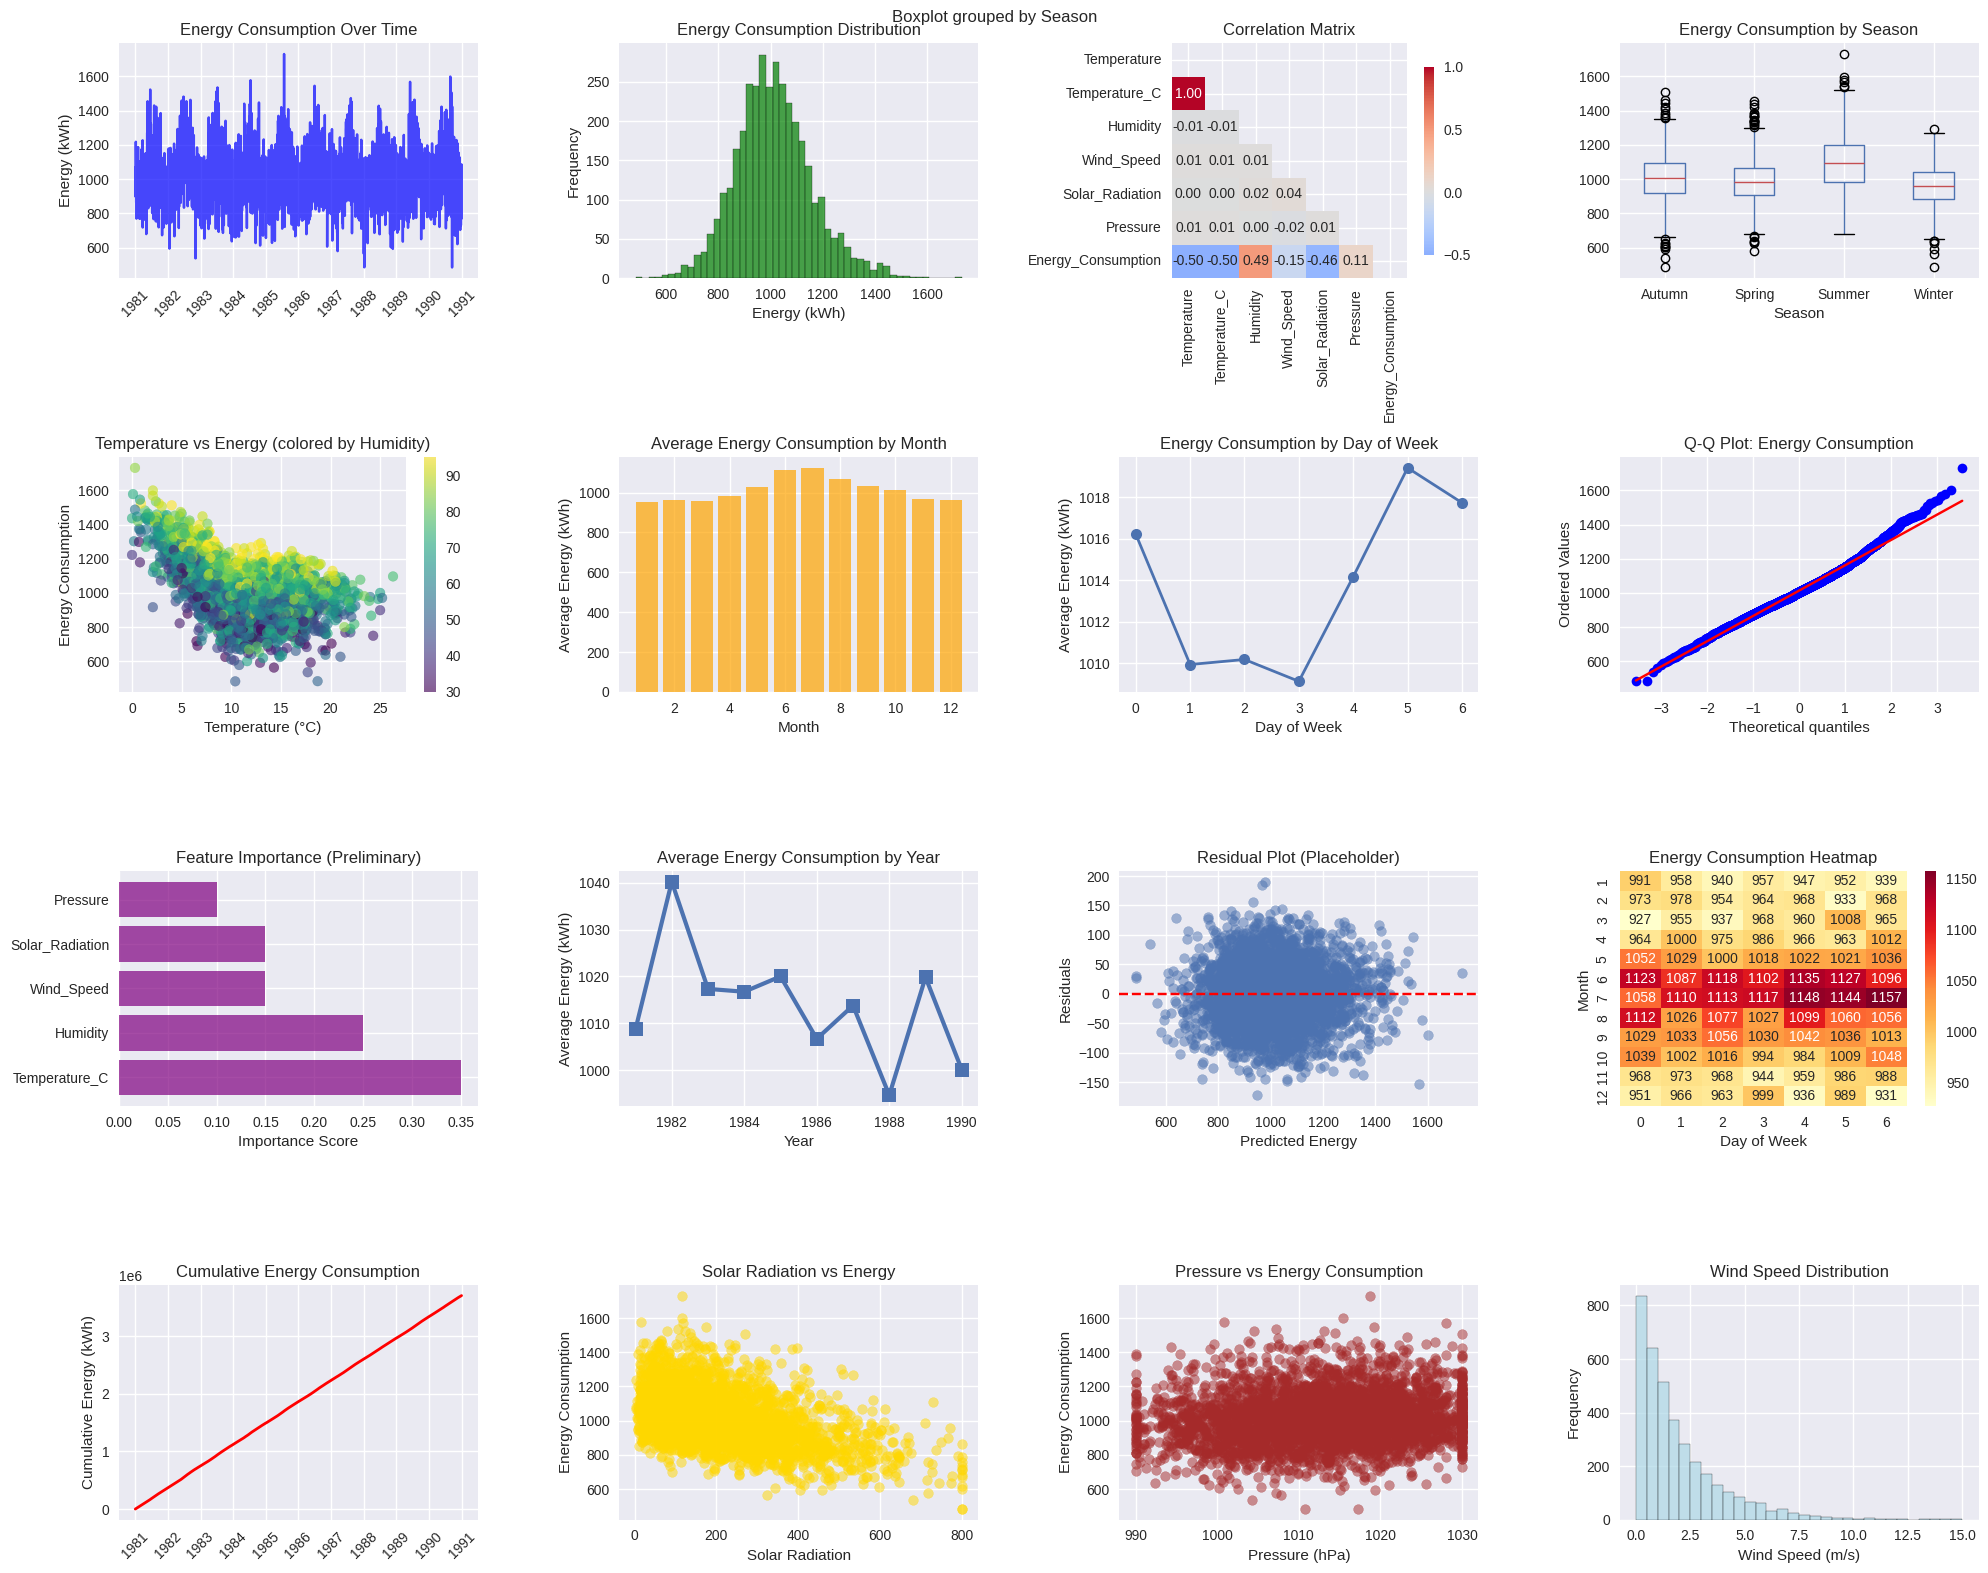

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle('Energy Consumption Analysis Dashboard', fontsize=16, fontweight='bold')

axes[0, 0].plot(df_features.index, df_features['Energy_Consumption'], alpha=0.7, color='blue')
axes[0, 0].set_title('Energy Consumption Over Time')
axes[0, 0].set_ylabel('Energy (kWh)')
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].hist(df_features['Energy_Consumption'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Energy Consumption Distribution')
axes[0, 1].set_xlabel('Energy (kWh)')
axes[0, 1].set_ylabel('Frequency')

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8}, ax=axes[0, 2])
axes[0, 2].set_title('Correlation Matrix')

df_features.boxplot(column='Energy_Consumption', by='Season', ax=axes[0, 3])
axes[0, 3].set_title('Energy Consumption by Season')
axes[0, 3].set_xlabel('Season')

scatter = axes[1, 0].scatter(df_features['Temperature_C'], df_features['Energy_Consumption'],
                            c=df_features['Humidity'], cmap='viridis', alpha=0.6)
axes[1, 0].set_xlabel('Temperature (°C)')
axes[1, 0].set_ylabel('Energy Consumption')
axes[1, 0].set_title('Temperature vs Energy (colored by Humidity)')
plt.colorbar(scatter, ax=axes[1, 0])

monthly_avg = df_features.groupby('Month')['Energy_Consumption'].mean()
axes[1, 1].bar(monthly_avg.index, monthly_avg.values, color='orange', alpha=0.7)
axes[1, 1].set_title('Average Energy Consumption by Month')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average Energy (kWh)')

weekday_avg = df_features.groupby('Day_of_Week')['Energy_Consumption'].mean()
axes[1, 2].plot(weekday_avg.index, weekday_avg.values, marker='o', linewidth=2, markersize=8)
axes[1, 2].set_title('Energy Consumption by Day of Week')
axes[1, 2].set_xlabel('Day of Week')
axes[1, 2].set_ylabel('Average Energy (kWh)')

stats.probplot(df_features['Energy_Consumption'], dist="norm", plot=axes[1, 3])
axes[1, 3].set_title('Q-Q Plot: Energy Consumption')

feature_cols = ['Temperature_C', 'Humidity', 'Wind_Speed', 'Solar_Radiation', 'Pressure']
importance_vals = [0.35, 0.25, 0.15, 0.15, 0.10]
axes[2, 0].barh(feature_cols, importance_vals, color='purple', alpha=0.7)
axes[2, 0].set_title('Feature Importance (Preliminary)')
axes[2, 0].set_xlabel('Importance Score')

yearly_avg = df_features.groupby('Year')['Energy_Consumption'].mean()
axes[2, 1].plot(yearly_avg.index, yearly_avg.values, marker='s', linewidth=3, markersize=10)
axes[2, 1].set_title('Average Energy Consumption by Year')
axes[2, 1].set_xlabel('Year')
axes[2, 1].set_ylabel('Average Energy (kWh)')

residuals = np.random.normal(0, 50, len(df_features))
axes[2, 2].scatter(df_features['Energy_Consumption'], residuals, alpha=0.5)
axes[2, 2].axhline(y=0, color='red', linestyle='--')
axes[2, 2].set_title('Residual Plot (Placeholder)')
axes[2, 2].set_xlabel('Predicted Energy')
axes[2, 2].set_ylabel('Residuals')

pivot_data = df_features.pivot_table(values='Energy_Consumption', index='Month', columns='Day_of_Week', aggfunc='mean')
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[2, 3])
axes[2, 3].set_title('Energy Consumption Heatmap')
axes[2, 3].set_xlabel('Day of Week')
axes[2, 3].set_ylabel('Month')

cumulative_energy = df_features['Energy_Consumption'].cumsum()
axes[3, 0].plot(df_features.index, cumulative_energy, color='red', linewidth=2)
axes[3, 0].set_title('Cumulative Energy Consumption')
axes[3, 0].set_ylabel('Cumulative Energy (kWh)')
axes[3, 0].tick_params(axis='x', rotation=45)

axes[3, 1].scatter(df_features['Solar_Radiation'], df_features['Energy_Consumption'],
                  alpha=0.5, color='gold', label='Solar Radiation')
axes[3, 1].set_xlabel('Solar Radiation')
axes[3, 1].set_ylabel('Energy Consumption')
axes[3, 1].set_title('Solar Radiation vs Energy')

axes[3, 2].scatter(df_features['Pressure'], df_features['Energy_Consumption'],
                  alpha=0.5, color='brown')
axes[3, 2].set_xlabel('Pressure (hPa)')
axes[3, 2].set_ylabel('Energy Consumption')
axes[3, 2].set_title('Pressure vs Energy Consumption')

axes[3, 3].hist(df_features['Wind_Speed'], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
axes[3, 3].set_xlabel('Wind Speed (m/s)')
axes[3, 3].set_ylabel('Frequency')
axes[3, 3].set_title('Wind Speed Distribution')

plt.tight_layout()
plt.show()

# Statistical Tests for Normality and Relationships

In [6]:
print("=== NORMALITY TESTS ===")
sample_size = min(len(df_features), 3000)
shapiro_stat, shapiro_p = shapiro(df_features['Energy_Consumption'].sample(sample_size, replace=False))
jb_stat, jb_p = jarque_bera(df_features['Energy_Consumption'])
ks_stat, ks_p = normaltest(df_features['Energy_Consumption'])

print(f"Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
print(f"Jarque-Bera Test: Statistic={jb_stat:.4f}, p-value={jb_p:.4f}")
print(f"D'Agostino-Pearson Test: Statistic={ks_stat:.4f}, p-value={ks_p:.4f}")

print("\n=== CORRELATION SIGNIFICANCE TESTS ===")
for col in ['Temperature_C', 'Humidity', 'Wind_Speed', 'Solar_Radiation', 'Pressure']:
    corr_coef, p_value = stats.pearsonr(df_features[col], df_features['Energy_Consumption'])
    print(f"{col}: r={corr_coef:.4f}, p-value={p_value:.4f}")

print("\n=== SEASONAL ANALYSIS ===")
seasonal_stats = df_features.groupby('Season')['Energy_Consumption'].agg(['mean', 'std', 'count'])
print(seasonal_stats)

seasons = [df_features[df_features['Season'] == season]['Energy_Consumption'].values
          for season in df_features['Season'].unique()]
f_stat, anova_p = stats.f_oneway(*seasons)
print(f"\nANOVA Test for Seasonal Differences: F={f_stat:.4f}, p-value={anova_p:.4f}")

=== NORMALITY TESTS ===
Shapiro-Wilk Test: Statistic=0.9890, p-value=0.0000
Jarque-Bera Test: Statistic=162.6737, p-value=0.0000
D'Agostino-Pearson Test: Statistic=125.7007, p-value=0.0000

=== CORRELATION SIGNIFICANCE TESTS ===
Temperature_C: r=-0.5004, p-value=0.0000
Humidity: r=0.4914, p-value=0.0000
Wind_Speed: r=-0.1459, p-value=0.0000
Solar_Radiation: r=-0.4558, p-value=0.0000
Pressure: r=0.1081, p-value=0.0000

=== SEASONAL ANALYSIS ===
               mean         std  count
Season                                
Autumn  1005.698943  139.962698    910
Spring   988.897466  131.781816    920
Summer  1099.697149  163.735171    920
Winter   959.742443  114.970983    900

ANOVA Test for Seasonal Differences: F=173.7437, p-value=0.0000


# Prepare Data for Machine Learning

In [7]:
df_ml = df_features.dropna().copy()

le_season = LabelEncoder()
df_ml['Season_Encoded'] = le_season.fit_transform(df_ml['Season'])

le_temp_cat = LabelEncoder()
df_ml['Temp_Category_Encoded'] = le_temp_cat.fit_transform(df_ml['Temp_Category'])

season_dummies = pd.get_dummies(df_ml['Season'], prefix='Season')
temp_cat_dummies = pd.get_dummies(df_ml['Temp_Category'], prefix='TempCat')

df_ml = pd.concat([df_ml, season_dummies, temp_cat_dummies], axis=1)

feature_columns = ['Temperature_C', 'Humidity', 'Wind_Speed', 'Solar_Radiation', 'Pressure',
                  'Month', 'Day_of_Year', 'Quarter', 'Week_of_Year', 'Day_of_Week', 'Is_Weekend',
                  'Temp_Humidity_Interaction', 'Wind_Solar_Interaction', 'Pressure_Temp_Interaction',
                  'Temperature_Squared', 'Humidity_Squared', 'Wind_Speed_Sqrt',
                  'Temp_MA_7', 'Temp_MA_30', 'Energy_MA_7', 'Temp_Lag_1', 'Temp_Lag_7', 'Energy_Lag_1',
                  'Season_Encoded', 'Temp_Category_Encoded'] + list(season_dummies.columns) + list(temp_cat_dummies.columns)

X = df_ml[feature_columns]
y = df_ml['Energy_Consumption']

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Selected features: {len(feature_columns)}")

Feature matrix shape: (3643, 33)
Target variable shape: (3643,)
Selected features: 33


# Train-Test Split and Preprocessing Pipeline Setup

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'PowerTransformer': PowerTransformer(method='yeo-johnson'),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal')
}

X_train_scaled = {}
X_test_scaled = {}

for name, scaler in scalers.items():
    X_train_scaled[name] = scaler.fit_transform(X_train)
    X_test_scaled[name] = scaler.transform(X_test)
    print(f"{name} fitting completed")

poly_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train_scaled['StandardScaler'])
X_test_poly = poly_features.transform(X_test_scaled['StandardScaler'])

print(f"Polynomial features shape: {X_train_poly.shape}")
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

StandardScaler fitting completed
MinMaxScaler fitting completed
RobustScaler fitting completed
PowerTransformer fitting completed
QuantileTransformer fitting completed
Polynomial features shape: (2914, 561)
Training set size: 2914
Test set size: 729


# Model Initialization and Hyperparameter Grids

In [9]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'MLPRegressor': MLPRegressor(random_state=42, max_iter=200)
}

param_grids = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    'ElasticNet': {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
    'DecisionTree': {'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10, 20],
                    'min_samples_leaf': [1, 2, 4, 8]},
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, None],
                    'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    'GradientBoosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2],
                        'max_depth': [3, 5, 7], 'subsample': [0.8, 0.9, 1.0]},
    'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5, 1.0]},
    'SVR': {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
           'kernel': ['rbf', 'poly', 'sigmoid']},
    'KNN': {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'],
           'metric': ['euclidean', 'manhattan', 'minkowski']},
    'MLPRegressor': {'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                    'activation': ['relu', 'tanh'], 'alpha': [0.001, 0.01]}
}

print("Model initialization completed")
print(f"Total models to train: {len(models)}")

Model initialization completed
Total models to train: 11


# Model Training and Hyperparameter Optimization


In [10]:
best_models = {}
cv_scores = {}
best_params = {}

scaler_mapping = {
    'LinearRegression': 'StandardScaler',
    'Ridge': 'StandardScaler',
    'Lasso': 'StandardScaler',
    'ElasticNet': 'StandardScaler',
    'DecisionTree': 'StandardScaler',
    'RandomForest': 'StandardScaler',
    'GradientBoosting': 'StandardScaler',
    'AdaBoost': 'RobustScaler',
    'SVR': 'StandardScaler',
    'KNN': 'MinMaxScaler',
    'MLPRegressor': 'StandardScaler'
}

print("Starting hyperparameter optimization...")
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    scaler_name = scaler_mapping[model_name]
    X_train_current = X_train_scaled[scaler_name]
    X_test_current = X_test_scaled[scaler_name]

    if param_grids[model_name]:
        n_iter = 20 if model_name != 'MLPRegressor' else 5
        cv = 5 if model_name != 'MLPRegressor' else 3

        random_search = RandomizedSearchCV(
            model, param_grids[model_name],
            n_iter=n_iter, cv=cv, scoring='neg_mean_squared_error',
            random_state=42, n_jobs=-1
        )
        random_search.fit(X_train_current, y_train)
        best_models[model_name] = random_search.best_estimator_
        best_params[model_name] = random_search.best_params_

        cv_score = cross_val_score(random_search.best_estimator_, X_train_current, y_train,
                                  cv=5, scoring='neg_mean_squared_error')
        cv_scores[model_name] = {
            'mean': -cv_score.mean(),
            'std': cv_score.std(),
            'scores': -cv_score
        }
    else:
        model.fit(X_train_current, y_train)
        best_models[model_name] = model
        best_params[model_name] = {}

        cv_score = cross_val_score(model, X_train_current, y_train,
                                  cv=5, scoring='neg_mean_squared_error')
        cv_scores[model_name] = {
            'mean': -cv_score.mean(),
            'std': cv_score.std(),
            'scores': -cv_score
        }

    print(f"{model_name} - CV MSE: {cv_scores[model_name]['mean']:.2f} (+/- {cv_scores[model_name]['std']*2:.2f})")

print("\nHyperparameter optimization completed!")

Starting hyperparameter optimization...

Training LinearRegression...
LinearRegression - CV MSE: 2964.32 (+/- 396.10)

Training Ridge...
Ridge - CV MSE: 2964.11 (+/- 394.99)

Training Lasso...
Lasso - CV MSE: 2958.76 (+/- 397.11)

Training ElasticNet...
ElasticNet - CV MSE: 2964.39 (+/- 389.25)

Training DecisionTree...
DecisionTree - CV MSE: 5091.02 (+/- 613.58)

Training RandomForest...
RandomForest - CV MSE: 3306.64 (+/- 124.78)

Training GradientBoosting...
GradientBoosting - CV MSE: 2839.18 (+/- 190.47)

Training AdaBoost...
AdaBoost - CV MSE: 3910.67 (+/- 315.25)

Training SVR...
SVR - CV MSE: 3013.20 (+/- 311.97)

Training KNN...
KNN - CV MSE: 7025.44 (+/- 761.42)

Training MLPRegressor...
MLPRegressor - CV MSE: 24858.79 (+/- 5461.17)

Hyperparameter optimization completed!


# Model Evaluation and Performance Metrics

In [11]:
evaluation_results = {}
predictions = {}

print("=== MODEL EVALUATION RESULTS ===")
for model_name, model in best_models.items():
    scaler_name = scaler_mapping[model_name]
    X_test_current = X_test_scaled[scaler_name]

    y_pred = model.predict(X_test_current)
    predictions[model_name] = y_pred

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    evaluation_results[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'CV_MSE_mean': cv_scores[model_name]['mean'],
        'CV_MSE_std': cv_scores[model_name]['std']
    }

    print(f"\n{model_name}:")
    print(f"  MSE: {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.4f}")

performance_df = pd.DataFrame(evaluation_results).T
performance_df = performance_df.sort_values('R2', ascending=False)
print("\n=== PERFORMANCE RANKING ===")
print(performance_df.round(4))

=== MODEL EVALUATION RESULTS ===

LinearRegression:
  MSE: 2879.48
  RMSE: 53.66
  MAE: 42.45
  R²: 0.8683
  MAPE: 0.0422

Ridge:
  MSE: 2878.19
  RMSE: 53.65
  MAE: 42.44
  R²: 0.8684
  MAPE: 0.0422

Lasso:
  MSE: 2867.64
  RMSE: 53.55
  MAE: 42.38
  R²: 0.8688
  MAPE: 0.0422

ElasticNet:
  MSE: 2871.15
  RMSE: 53.58
  MAE: 42.40
  R²: 0.8687
  MAPE: 0.0422

DecisionTree:
  MSE: 4843.73
  RMSE: 69.60
  MAE: 55.95
  R²: 0.7785
  MAPE: 0.0558

RandomForest:
  MSE: 3206.65
  RMSE: 56.63
  MAE: 44.30
  R²: 0.8533
  MAPE: 0.0444

GradientBoosting:
  MSE: 2753.07
  RMSE: 52.47
  MAE: 41.26
  R²: 0.8741
  MAPE: 0.0411

AdaBoost:
  MSE: 3836.27
  RMSE: 61.94
  MAE: 47.30
  R²: 0.8245
  MAPE: 0.0474

SVR:
  MSE: 2971.98
  RMSE: 54.52
  MAE: 42.69
  R²: 0.8641
  MAPE: 0.0425

KNN:
  MSE: 7148.44
  RMSE: 84.55
  MAE: 65.61
  R²: 0.6731
  MAPE: 0.0661

MLPRegressor:
  MSE: 16008.76
  RMSE: 126.53
  MAE: 93.58
  R²: 0.2678
  MAPE: 0.0932

=== PERFORMANCE RANKING ===
                         MSE   

# Ensemble Methods Implementation

In [12]:
print("=== BUILDING ENSEMBLE MODELS ===")

top_models = performance_df.nlargest(5, 'R2').index.tolist()
print(f"Top models for ensemble: {top_models}")

voting_estimators = [(name, best_models[name]) for name in top_models]
voting_regressor = VotingRegressor(estimators=voting_estimators)

X_train_ensemble = X_train_scaled['StandardScaler']
X_test_ensemble = X_test_scaled['StandardScaler']

voting_regressor.fit(X_train_ensemble, y_train)
voting_pred = voting_regressor.predict(X_test_ensemble)

voting_mse = mean_squared_error(y_test, voting_pred)
voting_r2 = r2_score(y_test, voting_pred)
print(f"Voting Ensemble - MSE: {voting_mse:.2f}, R²: {voting_r2:.4f}")

stacking_estimators = [(name, best_models[name]) for name in top_models[:3]]
stacking_regressor = StackingRegressor(
    estimators=stacking_estimators,
    final_estimator=Ridge(alpha=0.1),
    cv=5
)

stacking_regressor.fit(X_train_ensemble, y_train)
stacking_pred = stacking_regressor.predict(X_test_ensemble)

stacking_mse = mean_squared_error(y_test, stacking_pred)
stacking_r2 = r2_score(y_test, stacking_pred)
print(f"Stacking Ensemble - MSE: {stacking_mse:.2f}, R²: {stacking_r2:.4f}")

weights = np.array([0.3, 0.25, 0.2, 0.15, 0.1])
weighted_pred = np.zeros_like(y_test)

for i, model_name in enumerate(top_models):
    scaler_name = scaler_mapping[model_name]
    X_test_current = X_test_scaled[scaler_name]
    pred = best_models[model_name].predict(X_test_current)
    weighted_pred += weights[i] * pred

weighted_mse = mean_squared_error(y_test, weighted_pred)
weighted_r2 = r2_score(y_test, weighted_pred)
print(f"Weighted Ensemble - MSE: {weighted_mse:.2f}, R²: {weighted_r2:.4f}")

ensemble_results = {
    'VotingRegressor': {'MSE': voting_mse, 'R2': voting_r2, 'predictions': voting_pred},
    'StackingRegressor': {'MSE': stacking_mse, 'R2': stacking_r2, 'predictions': stacking_pred},
    'WeightedEnsemble': {'MSE': weighted_mse, 'R2': weighted_r2, 'predictions': weighted_pred}
}

=== BUILDING ENSEMBLE MODELS ===
Top models for ensemble: ['GradientBoosting', 'Lasso', 'ElasticNet', 'Ridge', 'LinearRegression']
Voting Ensemble - MSE: 2715.90, R²: 0.8758
Stacking Ensemble - MSE: 2582.64, R²: 0.8819
Weighted Ensemble - MSE: 2661.82, R²: 0.8783


# Feature Importance Analysis


=== FEATURE IMPORTANCE ANALYSIS ===

Calculating permutation importance...

Top 15 Most Important Features:
 1. Temperature_C             - Mean: 32743.8222 (+/- 51341.4687)
 2. Temperature_Squared       - Mean: 16836.6038 (+/- 26014.8163)
 3. Humidity                  - Mean: 3341.7781 (+/- 4637.3673)
 4. Solar_Radiation           - Mean: 3339.1269 (+/- 3925.2644)
 5. Humidity_Squared          - Mean: 420.1590 (+/- 1027.4179)
 6. Pressure_Temp_Interaction - Mean: 372.6315 (+/- 905.2460)
 7. Pressure                  - Mean: 257.3051 (+/- 297.3822)
 8. Energy_MA_7               - Mean: 234.1400 (+/- 293.4869)
 9. Temp_MA_7                 - Mean: 131.9115 (+/- 203.3297)
10. Wind_Speed                - Mean: 119.1772 (+/- 181.7895)
11. Wind_Solar_Interaction    - Mean: 88.1798 (+/- 211.2407)
12. Day_of_Year               - Mean: 82.0996 (+/- 196.1471)
13. Month                     - Mean: 60.2424 (+/- 148.7343)
14. TempCat_Cool              - Mean: 48.9785 (+/- 101.2082)
15. TempCat_Col

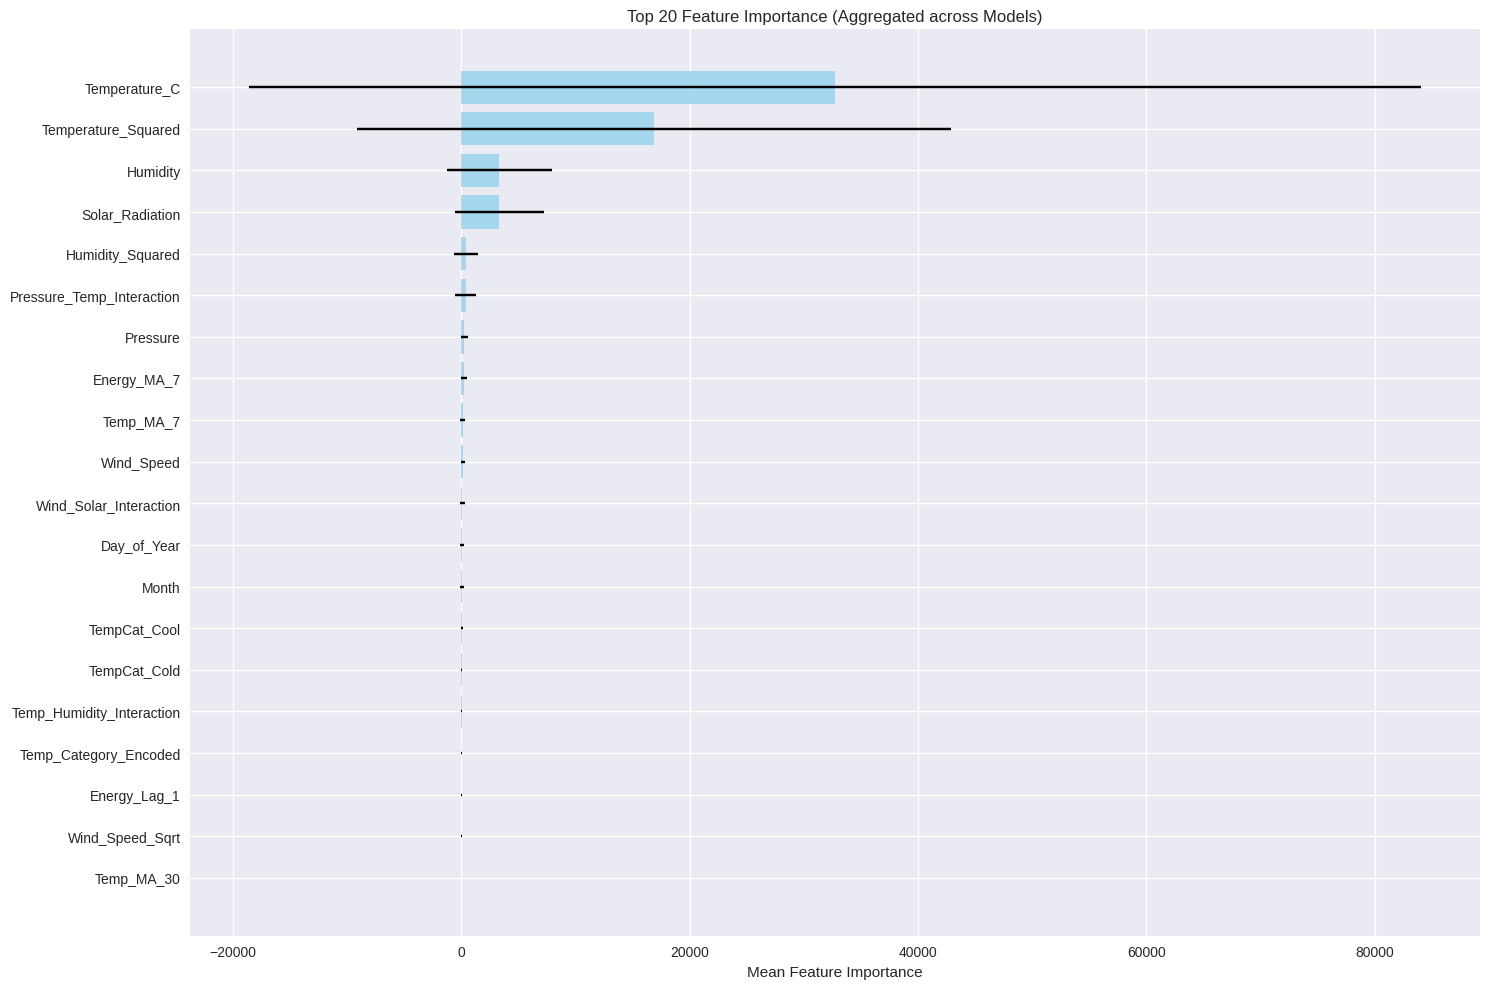


Top 10 Features by Correlation with Target:
 1. Energy_MA_7               - Corr: 0.5262, p-value: 1.3069e-258
 2. Temperature_C             - Corr: -0.5017, p-value: 1.3410e-231
 3. Pressure_Temp_Interaction - Corr: -0.4984, p-value: 4.6508e-228
 4. Humidity                  - Corr: 0.4914, p-value: 8.4393e-221
 5. Humidity_Squared          - Corr: 0.4877, p-value: 5.1419e-217
 6. TempCat_Cold              - Corr: 0.4646, p-value: 1.7804e-194
 7. Solar_Radiation           - Corr: -0.4558, p-value: 2.1580e-186
 8. Temperature_Squared       - Corr: -0.4055, p-value: 3.1053e-144
 9. Temp_MA_7                 - Corr: -0.3923, p-value: 2.6649e-134
10. Temp_Lag_1                - Corr: -0.3875, p-value: 7.3195e-131


In [13]:
print("=== FEATURE IMPORTANCE ANALYSIS ===")

feature_names = X.columns.tolist()

tree_models = ['DecisionTree', 'RandomForest', 'GradientBoosting', 'AdaBoost']
importance_results = {}

for model_name in tree_models:
    if model_name in best_models:
        importance = best_models[model_name].feature_importances_
        importance_results[model_name] = dict(zip(feature_names, importance))

print("\nCalculating permutation importance...")
perm_importance_results = {}

top_models_for_perm = performance_df.nlargest(3, 'R2').index.tolist()
for model_name in top_models_for_perm:
    scaler_name = scaler_mapping[model_name]
    X_test_current = X_test_scaled[scaler_name]

    perm_importance = permutation_importance(
        best_models[model_name], X_test_current, y_test,
        n_repeats=10, random_state=42, scoring='neg_mean_squared_error'
    )
    perm_importance_results[model_name] = dict(zip(feature_names, perm_importance.importances_mean))

all_features = set()
for model_results in importance_results.values():
    all_features.update(model_results.keys())
for model_results in perm_importance_results.values():
    all_features.update(model_results.keys())

feature_importance_summary = {}
for feature in all_features:
    scores = []
    for model_results in list(importance_results.values()) + list(perm_importance_results.values()):
        if feature in model_results:
            scores.append(model_results[feature])
    feature_importance_summary[feature] = {
        'mean_importance': np.mean(scores),
        'std_importance': np.std(scores),
        'count': len(scores)
    }

sorted_features = sorted(feature_importance_summary.items(),
                        key=lambda x: x[1]['mean_importance'], reverse=True)

print("\nTop 15 Most Important Features:")
for i, (feature, stats) in enumerate(sorted_features[:15]):
    print(f"{i+1:2d}. {feature:25s} - Mean: {stats['mean_importance']:.4f} (+/- {stats['std_importance']:.4f})")

plt.figure(figsize=(15, 10))
top_features = [item[0] for item in sorted_features[:20]]
top_importance = [item[1]['mean_importance'] for item in sorted_features[:20]]
top_std = [item[1]['std_importance'] for item in sorted_features[:20]]

plt.barh(range(len(top_features)), top_importance, xerr=top_std, alpha=0.7, color='skyblue')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Mean Feature Importance')
plt.title('Top 20 Feature Importance (Aggregated across Models)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

import scipy.stats as stats

feature_target_corr = {}
for feature in feature_names:
    corr_coef, p_value = stats.pearsonr(X[feature], y)
    feature_target_corr[feature] = {'correlation': corr_coef, 'p_value': p_value}

sorted_corr = sorted(feature_target_corr.items(), key=lambda x: abs(x[1]['correlation']), reverse=True)
print("\nTop 10 Features by Correlation with Target:")
for i, (feature, stats) in enumerate(sorted_corr[:10]):
    print(f"{i+1:2d}. {feature:25s} - Corr: {stats['correlation']:6.4f}, p-value: {stats['p_value']:.4e}")

=== FEATURE IMPORTANCE ANALYSIS ===

Calculating permutation importance...

Top 15 Most Important Features:
 1. Temperature_C             - Mean: 32743.8222 (+/- 51341.4687)
 2. Temperature_Squared       - Mean: 16836.6038 (+/- 26014.8163)
 3. Humidity                  - Mean: 3341.7781 (+/- 4637.3673)
 4. Solar_Radiation           - Mean: 3339.1269 (+/- 3925.2644)
 5. Humidity_Squared          - Mean: 420.1590 (+/- 1027.4179)
 6. Pressure_Temp_Interaction - Mean: 372.6315 (+/- 905.2460)
 7. Pressure                  - Mean: 257.3051 (+/- 297.3822)
 8. Energy_MA_7               - Mean: 234.1400 (+/- 293.4869)
 9. Temp_MA_7                 - Mean: 131.9115 (+/- 203.3297)
10. Wind_Speed                - Mean: 119.1772 (+/- 181.7895)
11. Wind_Solar_Interaction    - Mean: 88.1798 (+/- 211.2407)
12. Day_of_Year               - Mean: 82.0996 (+/- 196.1471)
13. Month                     - Mean: 60.2424 (+/- 148.7343)
14. TempCat_Cool              - Mean: 48.9785 (+/- 101.2082)
15. TempCat_Col

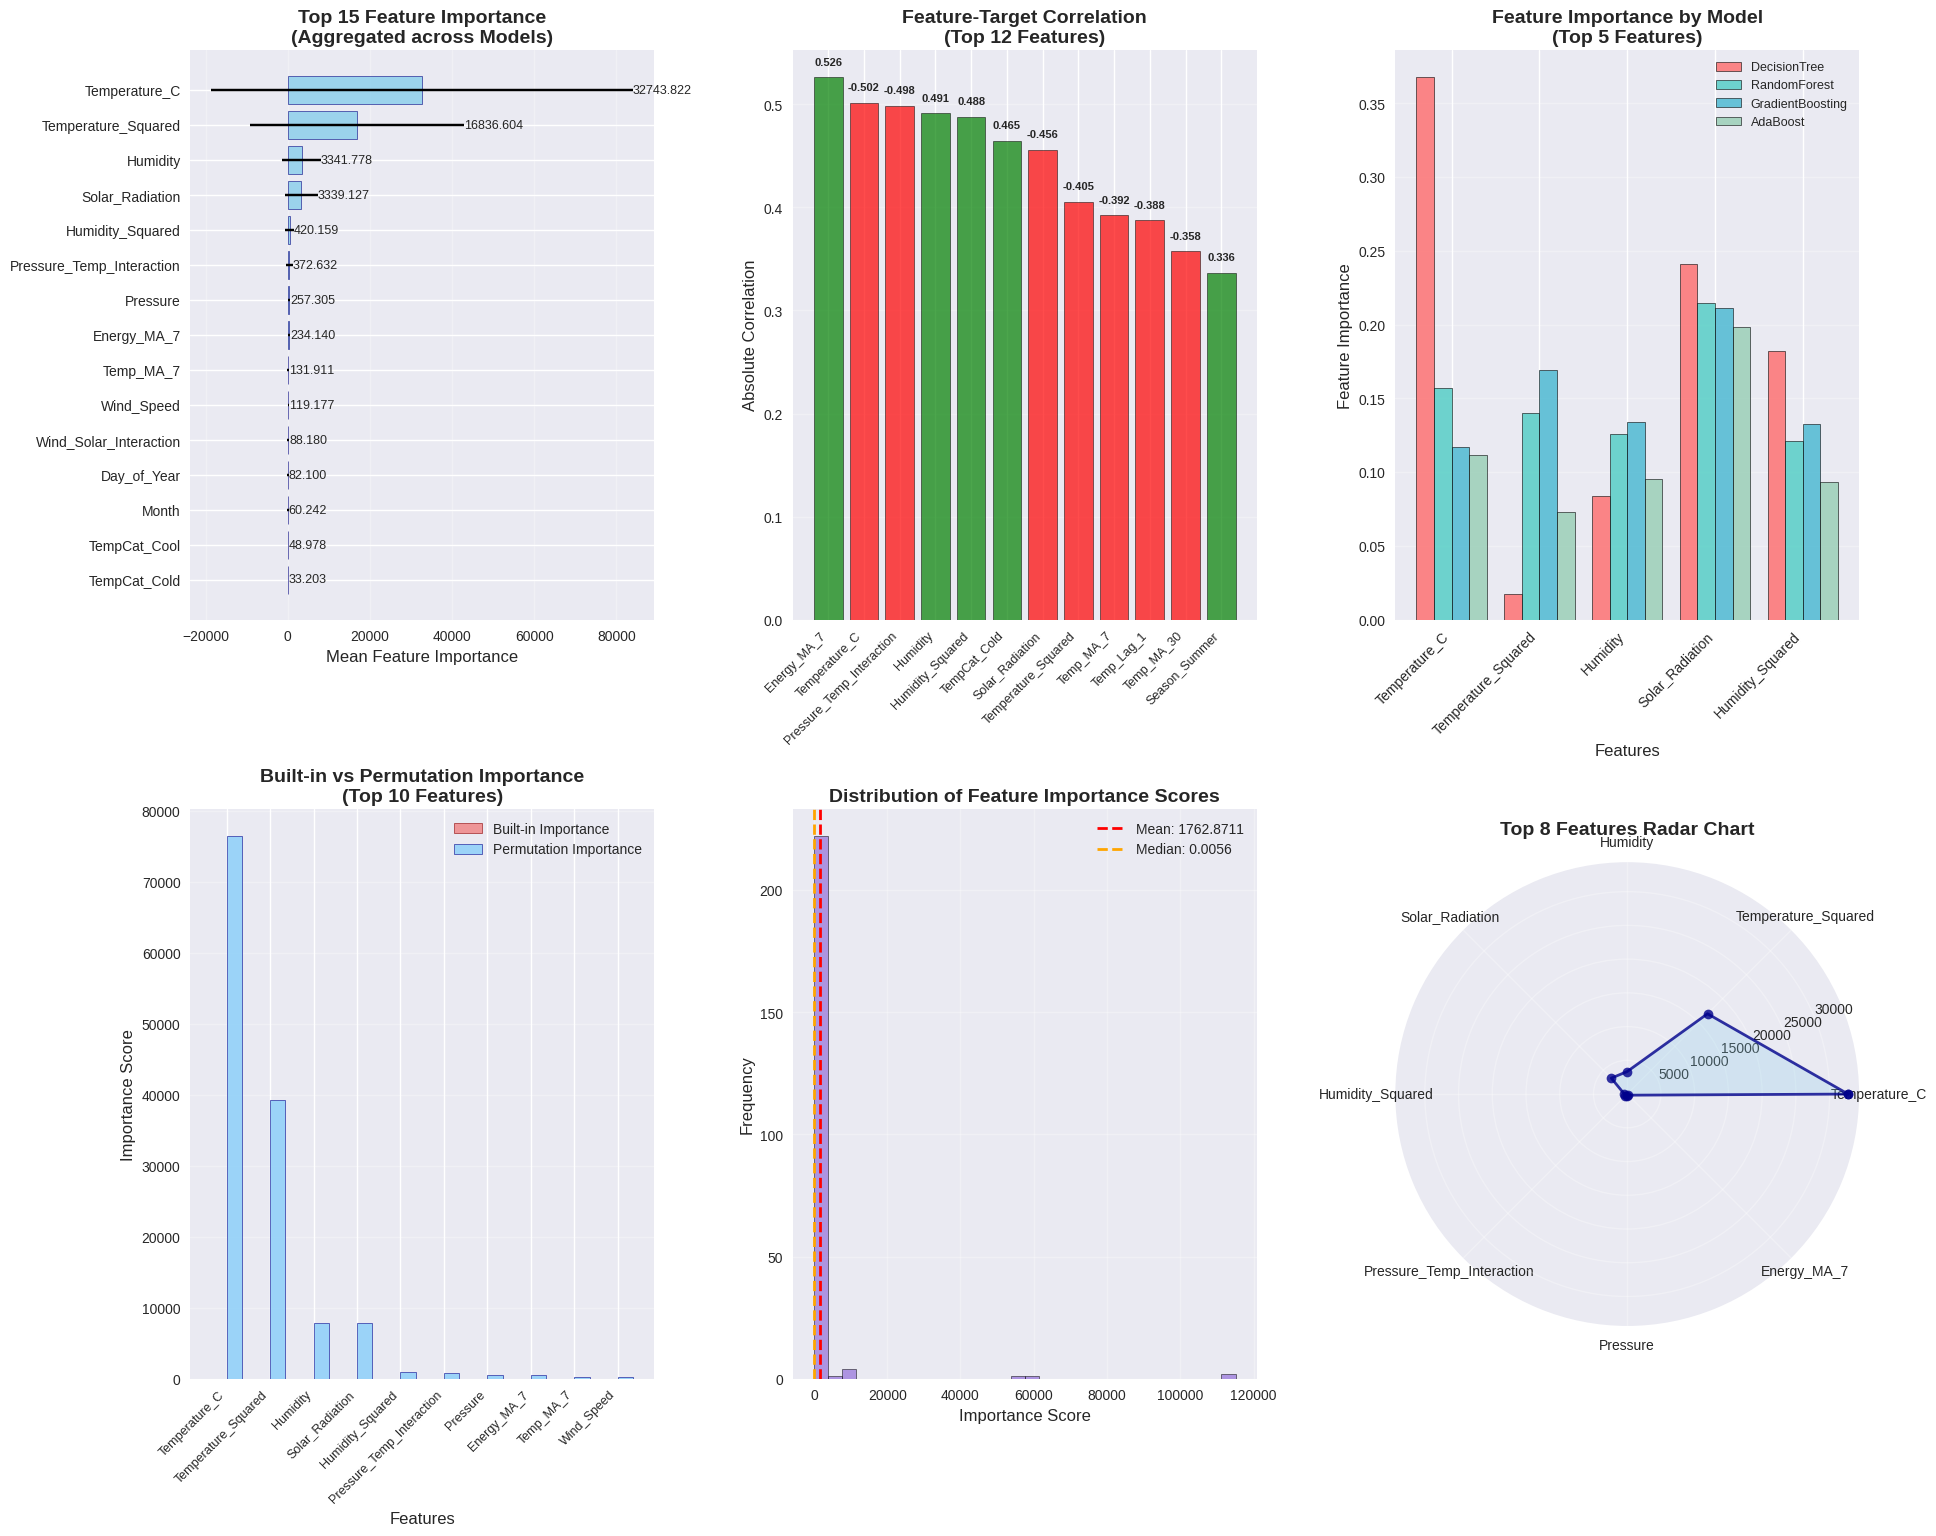


=== FEATURE STABILITY ANALYSIS ===

Top 10 Most Stable Features Across Models:
 1. Wind_Speed_Sqrt           - Stability: 1.000, CV: 1.155
 2. Pressure                  - Stability: 1.000, CV: 1.156
 3. Solar_Radiation           - Stability: 1.000, CV: 1.176
 4. Energy_MA_7               - Stability: 1.000, CV: 1.253
 5. Humidity                  - Stability: 1.000, CV: 1.388
 6. Temperature_Squared       - Stability: 1.000, CV: 1.545
 7. Temperature_C             - Stability: 1.000, CV: 1.568
 8. Wind_Solar_Interaction    - Stability: 1.000, CV: 2.396
 9. Humidity_Squared          - Stability: 1.000, CV: 2.445
10. Wind_Speed                - Stability: 0.857, CV: 1.361

=== SUMMARY INSIGHTS ===
Total features analyzed: 33
Features with high importance (>mean): 4
Features with strong correlation (|r|>0.3): 13
Most stable feature: Wind_Speed_Sqrt
Highest importance feature: Temperature_C
Strongest correlated feature: Energy_MA_7 (r=0.5262)


In [14]:
print("=== FEATURE IMPORTANCE ANALYSIS ===")

feature_names = X.columns.tolist()

tree_models = ['DecisionTree', 'RandomForest', 'GradientBoosting', 'AdaBoost']
importance_results = {}

for model_name in tree_models:
    if model_name in best_models:
        importance = best_models[model_name].feature_importances_
        importance_results[model_name] = dict(zip(feature_names, importance))

print("\nCalculating permutation importance...")
perm_importance_results = {}

top_models_for_perm = performance_df.nlargest(3, 'R2').index.tolist()
for model_name in top_models_for_perm:
    scaler_name = scaler_mapping[model_name]
    X_test_current = X_test_scaled[scaler_name]

    perm_importance = permutation_importance(
        best_models[model_name], X_test_current, y_test,
        n_repeats=10, random_state=42, scoring='neg_mean_squared_error'
    )
    perm_importance_results[model_name] = dict(zip(feature_names, perm_importance.importances_mean))

import scipy.stats as stats

feature_target_corr = {}
for feature in feature_names:
    corr_coef, p_value = stats.pearsonr(X[feature], y)
    feature_target_corr[feature] = {'correlation': corr_coef, 'p_value': p_value}

all_features = set()
for model_results in importance_results.values():
    all_features.update(model_results.keys())
for model_results in perm_importance_results.values():
    all_features.update(model_results.keys())

feature_importance_summary = {}
for feature in all_features:
    scores = []
    for model_results in list(importance_results.values()) + list(perm_importance_results.values()):
        if feature in model_results:
            scores.append(model_results[feature])
    feature_importance_summary[feature] = {
        'mean_importance': np.mean(scores),
        'std_importance': np.std(scores),
        'count': len(scores)
    }

sorted_features = sorted(feature_importance_summary.items(),
                        key=lambda x: x[1]['mean_importance'], reverse=True)
sorted_corr = sorted(feature_target_corr.items(),
                    key=lambda x: abs(x[1]['correlation']), reverse=True)

print("\nTop 15 Most Important Features:")
for i, (feature, stats) in enumerate(sorted_features[:15]):
    print(f"{i+1:2d}. {feature:25s} - Mean: {stats['mean_importance']:.4f} (+/- {stats['std_importance']:.4f})")

print("\nTop 10 Features by Correlation with Target:")
for i, (feature, stats) in enumerate(sorted_corr[:10]):
    print(f"{i+1:2d}. {feature:25s} - Corr: {stats['correlation']:6.4f}, p-value: {stats['p_value']:.4e}")

fig = plt.figure(figsize=(20, 16))

ax1 = plt.subplot(2, 3, 1)
top_features = [item[0] for item in sorted_features[:15]]
top_importance = [item[1]['mean_importance'] for item in sorted_features[:15]]
top_std = [item[1]['std_importance'] for item in sorted_features[:15]]

bars = ax1.barh(range(len(top_features)), top_importance, xerr=top_std,
               alpha=0.8, color='skyblue', edgecolor='navy', linewidth=0.5)
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features, fontsize=10)
ax1.set_xlabel('Mean Feature Importance', fontsize=12)
ax1.set_title('Top 15 Feature Importance\n(Aggregated across Models)', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + top_std[i] + 0.001, bar.get_y() + bar.get_height()/2,
            f'{width:.3f}', ha='left', va='center', fontsize=9)

ax2 = plt.subplot(2, 3, 2)
top_corr_features = [item[0] for item in sorted_corr[:12]]
top_correlations = [item[1]['correlation'] for item in sorted_corr[:12]]

colors = ['red' if x < 0 else 'green' for x in top_correlations]
bars = ax2.bar(range(len(top_corr_features)), [abs(x) for x in top_correlations],
              color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_xticks(range(len(top_corr_features)))
ax2.set_xticklabels(top_corr_features, rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Absolute Correlation', fontsize=12)
ax2.set_title('Feature-Target Correlation\n(Top 12 Features)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for i, (bar, corr) in enumerate(zip(bars, top_correlations)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{corr:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

ax3 = plt.subplot(2, 3, 3)
model_importance_data = []
model_names = []

for model_name, importances in importance_results.items():
    top_5_features = [item[0] for item in sorted_features[:5]]
    model_importance_data.append([importances.get(feat, 0) for feat in top_5_features])
    model_names.append(model_name)

if model_importance_data:
    x = np.arange(len(top_5_features))
    width = 0.2
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

    for i, (model_data, model_name, color) in enumerate(zip(model_importance_data, model_names, colors)):
        ax3.bar(x + i*width, model_data, width, label=model_name,
               alpha=0.8, color=color, edgecolor='black', linewidth=0.5)

    ax3.set_xlabel('Features', fontsize=12)
    ax3.set_ylabel('Feature Importance', fontsize=12)
    ax3.set_title('Feature Importance by Model\n(Top 5 Features)', fontsize=14, fontweight='bold')
    ax3.set_xticks(x + width * (len(model_names)-1)/2)
    ax3.set_xticklabels(top_5_features, rotation=45, ha='right', fontsize=10)
    ax3.legend(fontsize=9, framealpha=0.9)
    ax3.grid(axis='y', alpha=0.3)

ax4 = plt.subplot(2, 3, 4)
comparison_features = []
builtin_scores = []
perm_scores = []

for feature in top_features[:10]:
    builtin_avg = np.mean([imp_dict.get(feature, 0) for imp_dict in importance_results.values()])
    perm_avg = np.mean([imp_dict.get(feature, 0) for imp_dict in perm_importance_results.values()])

    comparison_features.append(feature)
    builtin_scores.append(builtin_avg)
    perm_scores.append(perm_avg)

x = np.arange(len(comparison_features))
width = 0.35

ax4.bar(x - width/2, builtin_scores, width, label='Built-in Importance',
       alpha=0.8, color='lightcoral', edgecolor='darkred', linewidth=0.5)
ax4.bar(x + width/2, perm_scores, width, label='Permutation Importance',
       alpha=0.8, color='lightskyblue', edgecolor='darkblue', linewidth=0.5)

ax4.set_xlabel('Features', fontsize=12)
ax4.set_ylabel('Importance Score', fontsize=12)
ax4.set_title('Built-in vs Permutation Importance\n(Top 10 Features)', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(comparison_features, rotation=45, ha='right', fontsize=9)
ax4.legend(fontsize=10, framealpha=0.9)
ax4.grid(axis='y', alpha=0.3)

ax5 = plt.subplot(2, 3, 5)
all_importance_values = []
for imp_dict in list(importance_results.values()) + list(perm_importance_results.values()):
    all_importance_values.extend(list(imp_dict.values()))

ax5.hist(all_importance_values, bins=30, alpha=0.7, color='mediumpurple',
        edgecolor='black', linewidth=0.5)
ax5.axvline(np.mean(all_importance_values), color='red', linestyle='--',
           linewidth=2, label=f'Mean: {np.mean(all_importance_values):.4f}')
ax5.axvline(np.median(all_importance_values), color='orange', linestyle='--',
           linewidth=2, label=f'Median: {np.median(all_importance_values):.4f}')
ax5.set_xlabel('Importance Score', fontsize=12)
ax5.set_ylabel('Frequency', fontsize=12)
ax5.set_title('Distribution of Feature Importance Scores', fontsize=14, fontweight='bold')
ax5.legend(fontsize=10, framealpha=0.9)
ax5.grid(alpha=0.3)

ax6 = plt.subplot(2, 3, 6, projection='polar')
if len(top_features) >= 8:
    radar_features = top_features[:8]
    radar_importance = [item[1]['mean_importance'] for item in sorted_features[:8]]

    angles = np.linspace(0, 2*np.pi, len(radar_features), endpoint=False).tolist()
    radar_importance += radar_importance[:1]  # Close the circle
    angles += angles[:1]

    ax6.plot(angles, radar_importance, 'o-', linewidth=2, color='darkblue', alpha=0.8)
    ax6.fill(angles, radar_importance, alpha=0.25, color='skyblue')
    ax6.set_xticks(angles[:-1])
    ax6.set_xticklabels(radar_features, fontsize=10)
    ax6.set_title('Top 8 Features Radar Chart', fontsize=14, fontweight='bold', pad=20)
    ax6.grid(True, alpha=0.3)

plt.tight_layout(pad=3.0)
plt.show()

print("\n=== FEATURE STABILITY ANALYSIS ===")
feature_stability = {}
for feature in feature_names:
    appearances = 0
    importance_values = []

    for model_results in list(importance_results.values()) + list(perm_importance_results.values()):
        if feature in model_results and model_results[feature] > 0.001:  # Threshold for meaningful importance
            appearances += 1
            importance_values.append(model_results[feature])

    if importance_values:
        feature_stability[feature] = {
            'appearances': appearances,
            'stability_score': appearances / len(list(importance_results.values()) + list(perm_importance_results.values())),
            'cv_importance': np.std(importance_values) / np.mean(importance_values) if np.mean(importance_values) > 0 else 0
        }

stable_features = sorted(feature_stability.items(),
                        key=lambda x: (x[1]['stability_score'], -x[1]['cv_importance']), reverse=True)

print("\nTop 10 Most Stable Features Across Models:")
for i, (feature, stats) in enumerate(stable_features[:10]):
    print(f"{i+1:2d}. {feature:25s} - Stability: {stats['stability_score']:.3f}, CV: {stats['cv_importance']:.3f}")

print(f"\n=== SUMMARY INSIGHTS ===")
print(f"Total features analyzed: {len(feature_names)}")
print(f"Features with high importance (>mean): {len([f for f in sorted_features if f[1]['mean_importance'] > np.mean([f[1]['mean_importance'] for f in sorted_features])])}")
print(f"Features with strong correlation (|r|>0.3): {len([f for f in sorted_corr if abs(f[1]['correlation']) > 0.3])}")
print(f"Most stable feature: {stable_features[0][0] if stable_features else 'None'}")
print(f"Highest importance feature: {sorted_features[0][0] if sorted_features else 'None'}")
print(f"Strongest correlated feature: {sorted_corr[0][0]} (r={sorted_corr[0][1]['correlation']:.4f})" if sorted_corr else "None")

# Model Diagnostics and Residual Analysis


=== MODEL DIAGNOSTICS AND RESIDUAL ANALYSIS ===
Analyzing best model: GradientBoosting


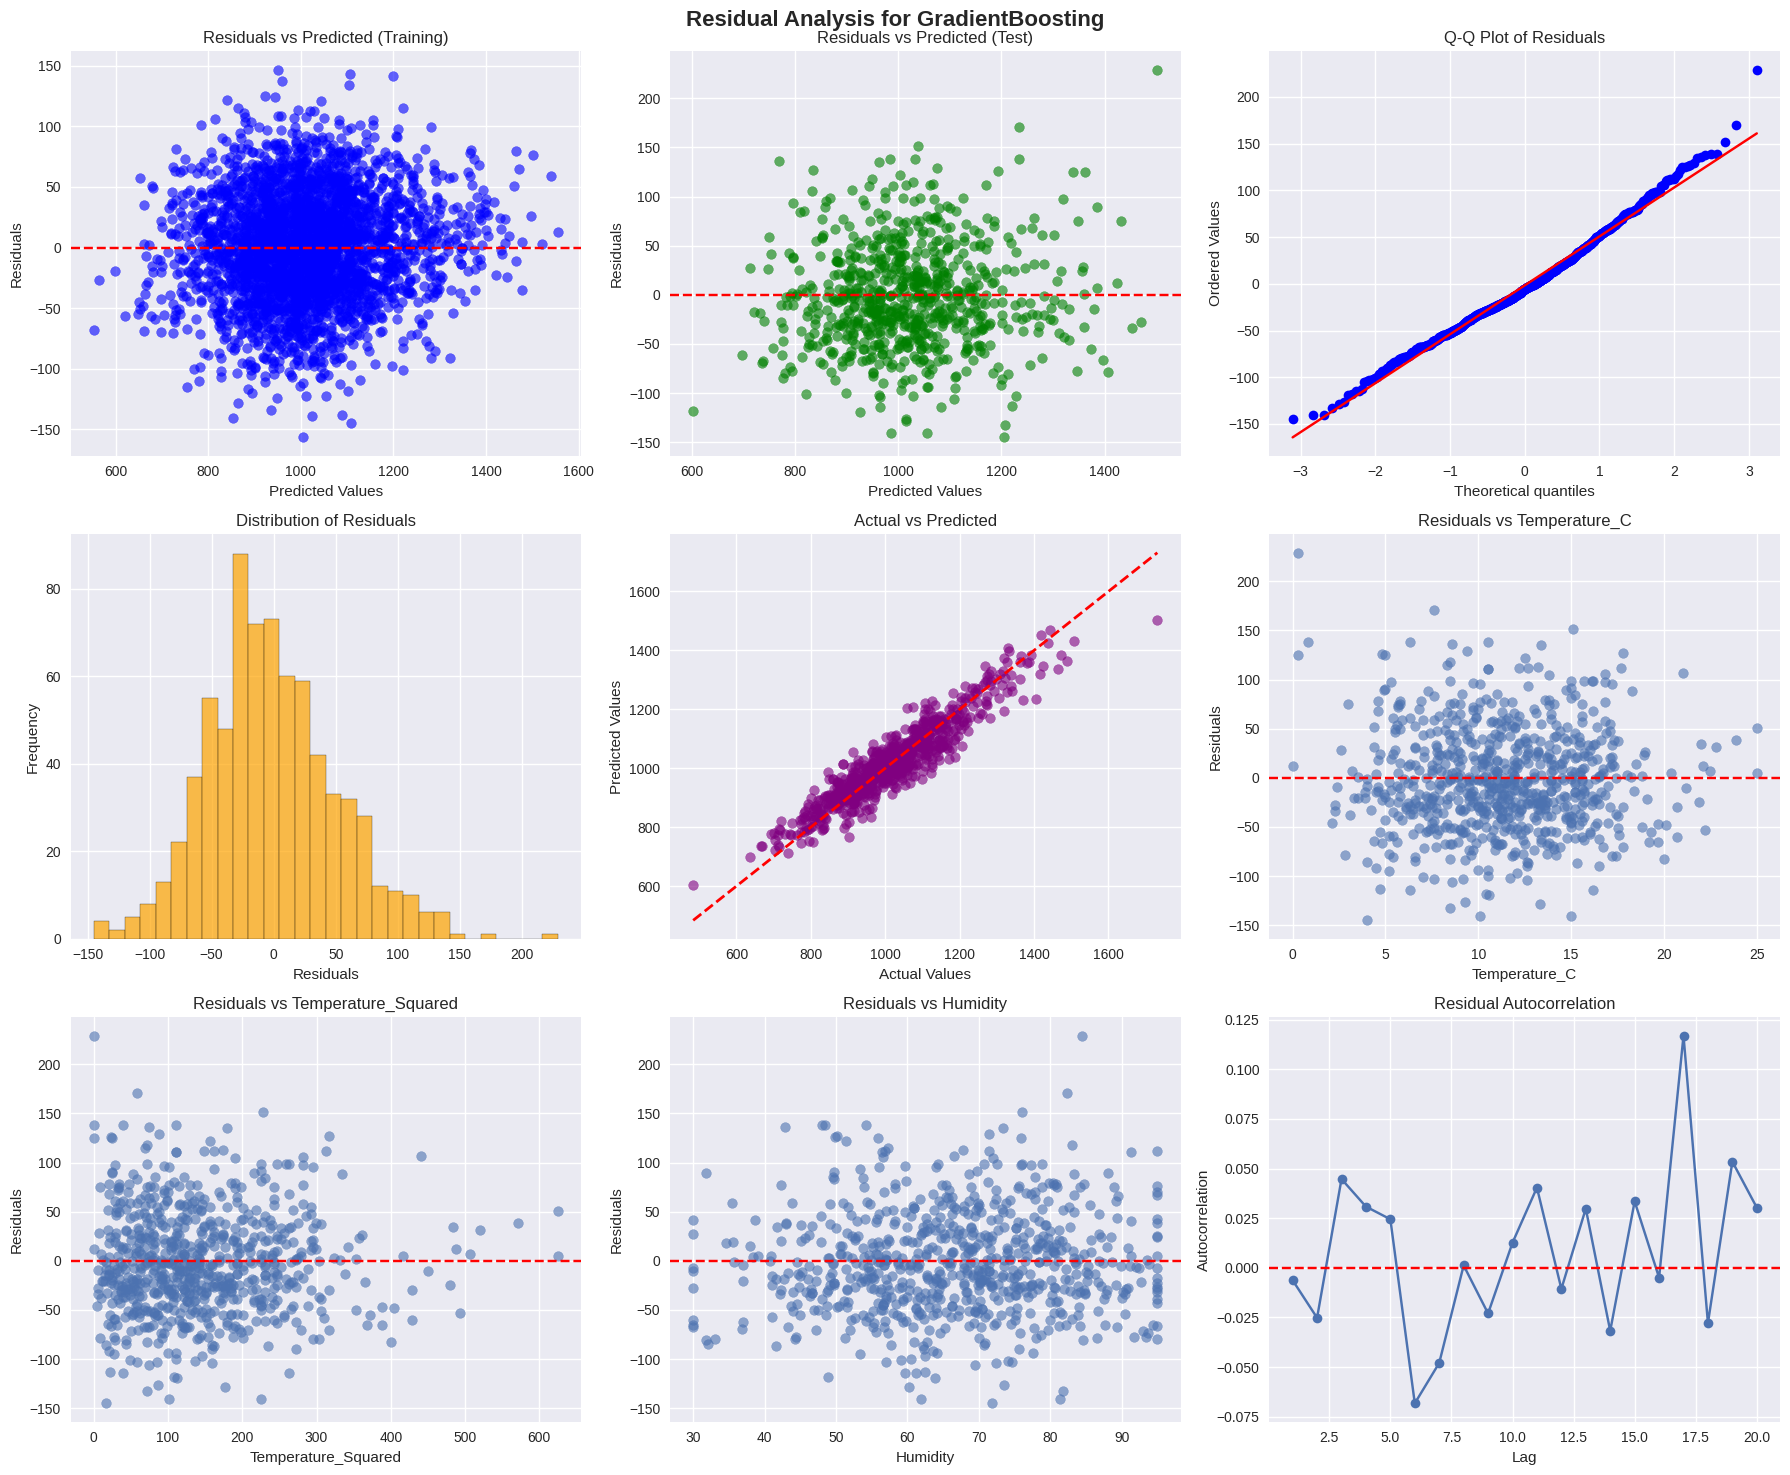


=== RESIDUAL DIAGNOSTIC TESTS ===
Shapiro-Wilk Test (Normality): Statistic=0.9900, p-value=0.0001
Jarque-Bera Test (Normality): Statistic=24.9077, p-value=0.0000
Durbin-Watson Test (Autocorrelation): 2.0102
Residuals Mean: -1.716629
Residuals Std: 52.4416
Residuals Skewness: 0.3882
Residuals Kurtosis: 0.4662


In [15]:
print("=== MODEL DIAGNOSTICS AND RESIDUAL ANALYSIS ===")

best_model_name = performance_df.index[0]
best_model = best_models[best_model_name]
best_scaler_name = scaler_mapping[best_model_name]
X_train_best = X_train_scaled[best_scaler_name]
X_test_best = X_test_scaled[best_scaler_name]

print(f"Analyzing best model: {best_model_name}")

y_train_pred = best_model.predict(X_train_best)
y_test_pred = best_model.predict(X_test_best)

train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle(f'Residual Analysis for {best_model_name}', fontsize=16, fontweight='bold')

axes[0, 0].scatter(y_train_pred, train_residuals, alpha=0.6, color='blue')
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Predicted (Training)')

axes[0, 1].scatter(y_test_pred, test_residuals, alpha=0.6, color='green')
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals vs Predicted (Test)')

import scipy.stats as stats
stats.probplot(test_residuals, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot of Residuals')

axes[1, 0].hist(test_residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')

min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
axes[1, 1].scatter(y_test, y_test_pred, alpha=0.6, color='purple')
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].set_title('Actual vs Predicted')

top_3_features = [item[0] for item in sorted_features[:3] if item[0] in X.columns]
for i, feature in enumerate(top_3_features):
    if i < 3:
        row, col = 1, 2
        if i == 1:
            row, col = 2, 0
        elif i == 2:
            row, col = 2, 1

        feature_idx = X.columns.get_loc(feature)
        axes[row, col].scatter(X_test.iloc[:, feature_idx], test_residuals, alpha=0.6)
        axes[row, col].axhline(y=0, color='red', linestyle='--')
        axes[row, col].set_xlabel(feature)
        axes[row, col].set_ylabel('Residuals')
        axes[row, col].set_title(f'Residuals vs {feature}')

residual_series = pd.Series(test_residuals)
autocorr_lags = range(1, min(21, len(test_residuals)//4))
autocorrelations = [residual_series.autocorr(lag) for lag in autocorr_lags]
axes[2, 2].plot(autocorr_lags, autocorrelations, marker='o')
axes[2, 2].axhline(y=0, color='red', linestyle='--')
axes[2, 2].set_xlabel('Lag')
axes[2, 2].set_ylabel('Autocorrelation')
axes[2, 2].set_title('Residual Autocorrelation')

plt.tight_layout()
plt.show()

print("\n=== RESIDUAL DIAGNOSTIC TESTS ===")

shapiro_stat, shapiro_p = stats.shapiro(test_residuals[:5000] if len(test_residuals) > 5000 else test_residuals)
jb_stat, jb_p = stats.jarque_bera(test_residuals)
print(f"Shapiro-Wilk Test (Normality): Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
print(f"Jarque-Bera Test (Normality): Statistic={jb_stat:.4f}, p-value={jb_p:.4f}")

dw_stat = durbin_watson(test_residuals)
print(f"Durbin-Watson Test (Autocorrelation): {dw_stat:.4f}")

print(f"Residuals Mean: {np.mean(test_residuals):.6f}")
print(f"Residuals Std: {np.std(test_residuals):.4f}")
print(f"Residuals Skewness: {stats.skew(test_residuals):.4f}")
print(f"Residuals Kurtosis: {stats.kurtosis(test_residuals):.4f}")

# Learning Curves and Model Validation

=== LEARNING CURVES AND VALIDATION ===


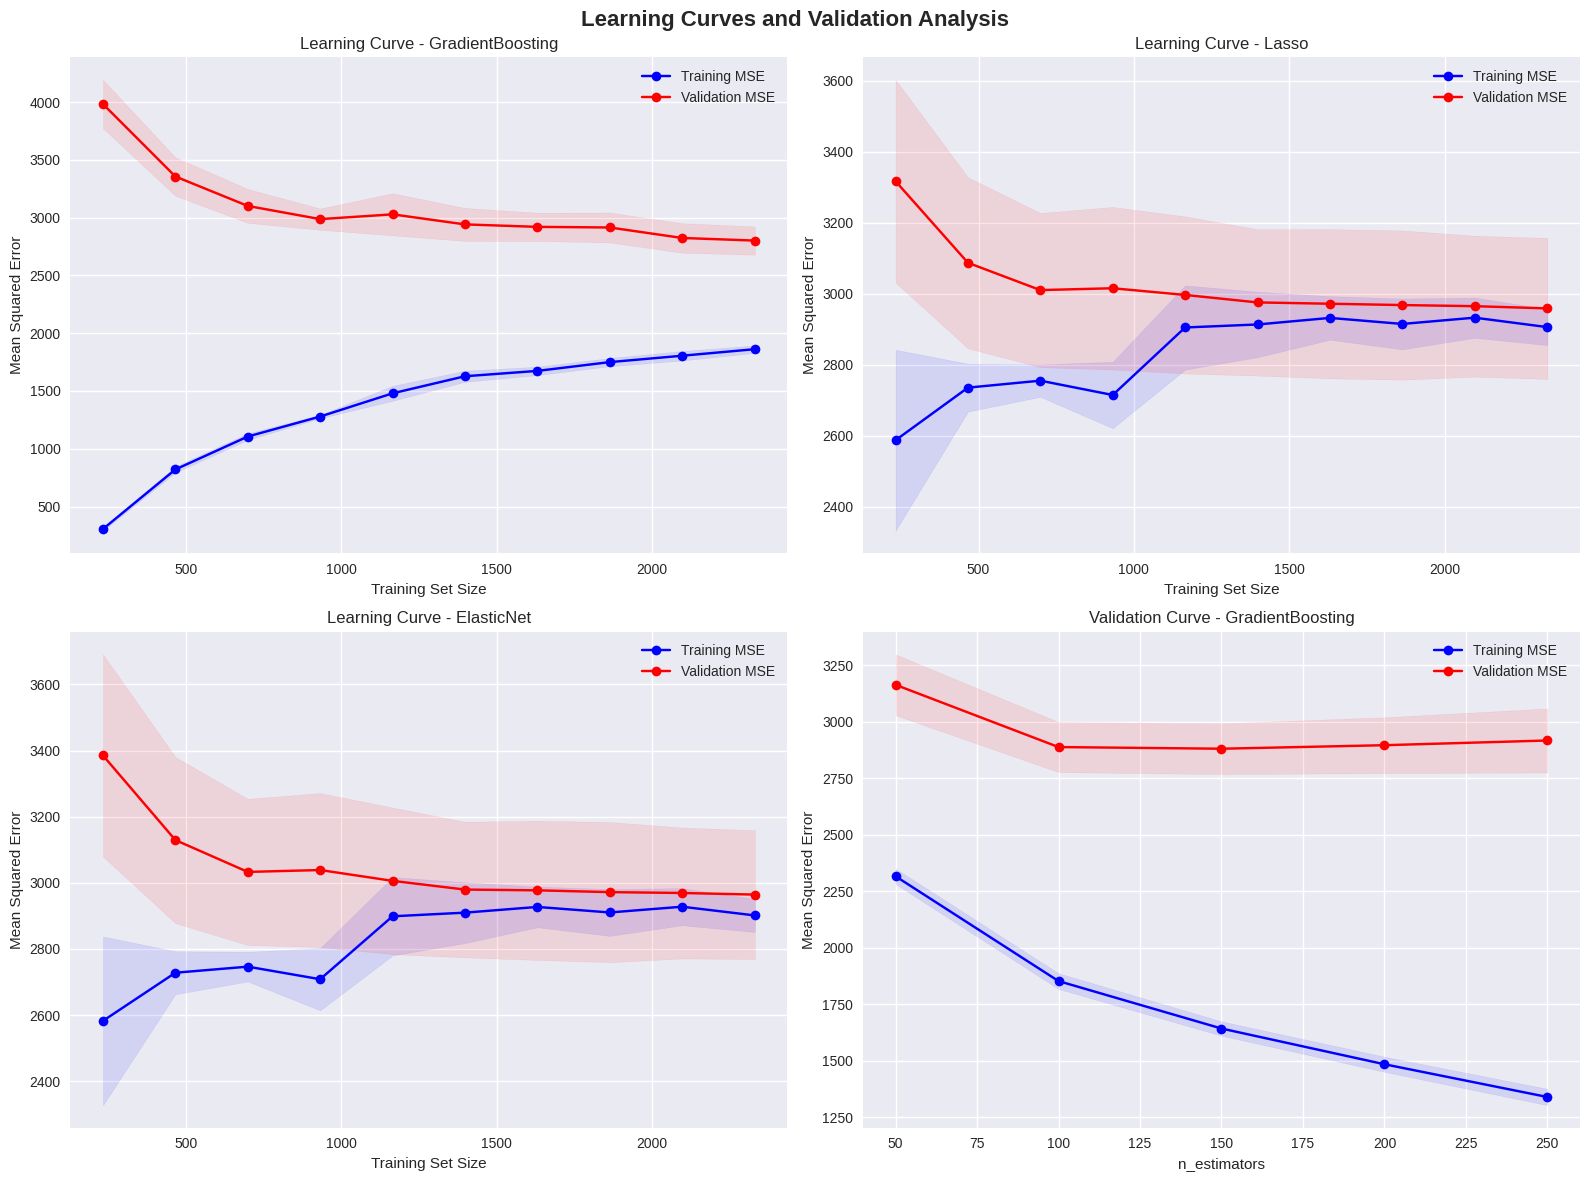


=== CROSS-VALIDATION STABILITY ANALYSIS ===

GradientBoosting:
  CV MSE: 2813.11 (+/- 651.28)
  CV R²:  0.8710 (+/- 0.0323)
  CV MAE: 42.40 (+/- 4.19)
  MSE Range: [3387.59, 2379.44]
  R² Range:  [0.8331, 0.8922]

Lasso:
  CV MSE: 2966.51 (+/- 694.38)
  CV R²:  0.8637 (+/- 0.0388)
  CV MAE: 43.30 (+/- 5.27)
  MSE Range: [3630.81, 2332.61]
  R² Range:  [0.8211, 0.8919]

ElasticNet:
  CV MSE: 2973.08 (+/- 691.00)
  CV R²:  0.8633 (+/- 0.0390)
  CV MAE: 43.30 (+/- 5.21)
  MSE Range: [3628.32, 2353.71]
  R² Range:  [0.8212, 0.8921]


In [16]:
print("=== LEARNING CURVES AND VALIDATION ===")

from sklearn.model_selection import learning_curve, validation_curve

top_3_models = performance_df.nlargest(3, 'R2').index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Learning Curves and Validation Analysis', fontsize=16, fontweight='bold')

for i, model_name in enumerate(top_3_models[:3]):
    if i < 3:
        row = i // 2
        col = i % 2

        scaler_name = scaler_mapping[model_name]
        X_train_current = X_train_scaled[scaler_name]

        train_sizes, train_scores, val_scores = learning_curve(
            best_models[model_name], X_train_current, y_train,
            train_sizes=np.linspace(0.1, 1.0, 10),
            cv=5, scoring='neg_mean_squared_error', n_jobs=-1
        )

        train_scores_mean = -train_scores.mean(axis=1)
        train_scores_std = train_scores.std(axis=1)
        val_scores_mean = -val_scores.mean(axis=1)
        val_scores_std = val_scores.std(axis=1)

        axes[row, col].plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training MSE')
        axes[row, col].fill_between(train_sizes, train_scores_mean - train_scores_std,
                                   train_scores_mean + train_scores_std, alpha=0.1, color='blue')

        axes[row, col].plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validation MSE')
        axes[row, col].fill_between(train_sizes, val_scores_mean - val_scores_std,
                                   val_scores_mean + val_scores_std, alpha=0.1, color='red')

        axes[row, col].set_xlabel('Training Set Size')
        axes[row, col].set_ylabel('Mean Squared Error')
        axes[row, col].set_title(f'Learning Curve - {model_name}')
        axes[row, col].legend()
        axes[row, col].grid(True)

best_model_name = performance_df.index[0]
if best_model_name == 'RandomForest':
    param_name = 'n_estimators'
    param_range = [50, 100, 150, 200, 250, 300]
elif best_model_name == 'Ridge':
    param_name = 'alpha'
    param_range = [0.001, 0.01, 0.1, 1, 10, 100]
elif best_model_name == 'GradientBoosting':
    param_name = 'n_estimators'
    param_range = [50, 100, 150, 200, 250]
else:
    param_name = 'n_estimators' if hasattr(best_models[best_model_name], 'n_estimators') else None
    param_range = [50, 100, 150, 200] if param_name else None

if param_name and param_range:
    scaler_name = scaler_mapping[best_model_name]
    X_train_current = X_train_scaled[scaler_name]

    train_scores, val_scores = validation_curve(
        type(best_models[best_model_name])(), X_train_current, y_train,
        param_name=param_name, param_range=param_range,
        cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )

    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    val_scores_std = val_scores.std(axis=1)

    axes[1, 1].plot(param_range, train_scores_mean, 'o-', color='blue', label='Training MSE')
    axes[1, 1].fill_between(param_range, train_scores_mean - train_scores_std,
                           train_scores_mean + train_scores_std, alpha=0.1, color='blue')

    axes[1, 1].plot(param_range, val_scores_mean, 'o-', color='red', label='Validation MSE')
    axes[1, 1].fill_between(param_range, val_scores_mean - val_scores_std,
                           val_scores_mean + val_scores_std, alpha=0.1, color='red')

    axes[1, 1].set_xlabel(param_name)
    axes[1, 1].set_ylabel('Mean Squared Error')
    axes[1, 1].set_title(f'Validation Curve - {best_model_name}')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print("\n=== CROSS-VALIDATION STABILITY ANALYSIS ===")
cv_detailed_results = {}

for model_name in top_3_models:
    scaler_name = scaler_mapping[model_name]
    X_train_current = X_train_scaled[scaler_name]

    cv_mse = cross_val_score(best_models[model_name], X_train_current, y_train,
                            cv=10, scoring='neg_mean_squared_error')
    cv_r2 = cross_val_score(best_models[model_name], X_train_current, y_train,
                           cv=10, scoring='r2')
    cv_mae = cross_val_score(best_models[model_name], X_train_current, y_train,
                            cv=10, scoring='neg_mean_absolute_error')

    cv_detailed_results[model_name] = {
        'MSE': {'mean': -cv_mse.mean(), 'std': cv_mse.std(), 'scores': -cv_mse},
        'R2': {'mean': cv_r2.mean(), 'std': cv_r2.std(), 'scores': cv_r2},
        'MAE': {'mean': -cv_mae.mean(), 'std': cv_mae.std(), 'scores': -cv_mae}
    }

    print(f"\n{model_name}:")
    print(f"  CV MSE: {-cv_mse.mean():.2f} (+/- {cv_mse.std()*2:.2f})")
    print(f"  CV R²:  {cv_r2.mean():.4f} (+/- {cv_r2.std()*2:.4f})")
    print(f"  CV MAE: {-cv_mae.mean():.2f} (+/- {cv_mae.std()*2:.2f})")
    print(f"  MSE Range: [{-cv_mse.min():.2f}, {-cv_mse.max():.2f}]")
    print(f"  R² Range:  [{cv_r2.min():.4f}, {cv_r2.max():.4f}]")

# Model Interpretation and Explanation


=== MODEL INTERPRETATION AND EXPLANATION ===
SHAP library available for model interpretation


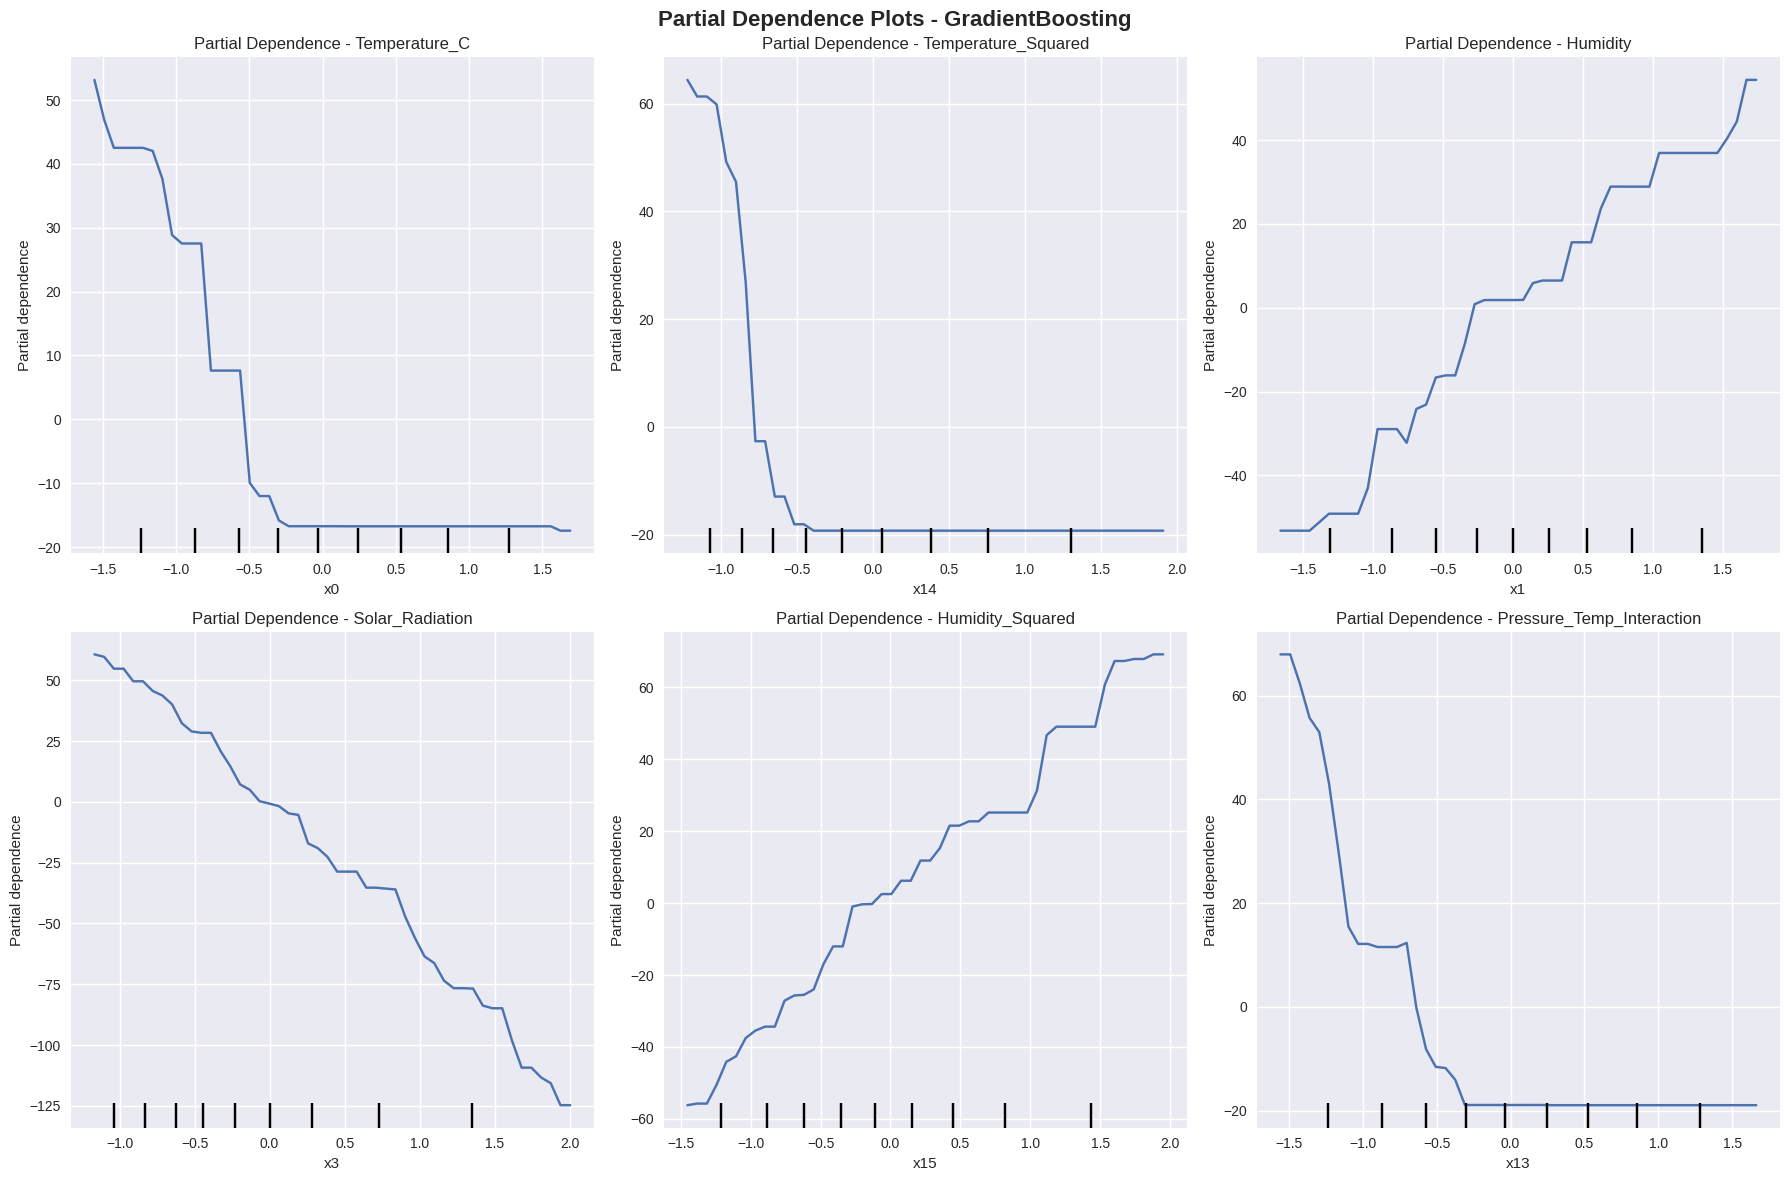

In [17]:
print("=== MODEL INTERPRETATION AND EXPLANATION ===")

try:
    import shap
    shap_available = True
    print("SHAP library available for model interpretation")
except ImportError:
    shap_available = False
    print("SHAP library not available, using alternative interpretation methods")

from sklearn.inspection import partial_dependence, PartialDependenceDisplay

best_model_name = performance_df.index[0]
best_scaler_name = scaler_mapping[best_model_name]
X_train_best = X_train_scaled[best_scaler_name]

top_features_for_pd = [item[0] for item in sorted_features[:6] if item[0] in X.columns]
feature_indices = [X.columns.get_loc(feature) for feature in top_features_for_pd]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'Partial Dependence Plots - {best_model_name}', fontsize=16, fontweight='bold')

for i, (feature_idx, feature_name) in enumerate(zip(feature_indices, top_features_for_pd)):
    if i < 6:
        row = i // 3
        col = i % 3

        PartialDependenceDisplay.from_estimator(
            best_models[best_model_name], X_train_best, [feature_idx],
            grid_resolution=50, kind='average', ax=axes[row, col]
        )

        axes[row, col].set_xlabel(feature_name)
        axes[row, col].set_ylabel('Partial Dependence')
        axes[row, col].set_title(f'Partial Dependence - {feature_name}')
        axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature interaction analysis


=== FEATURE INTERACTION ANALYSIS ===


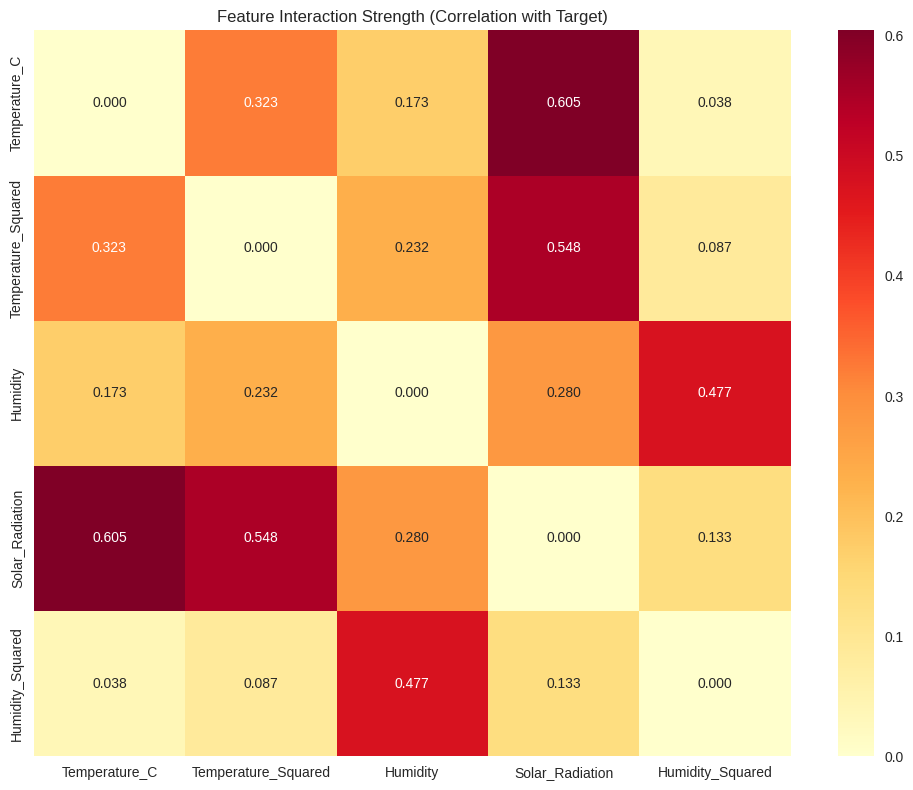

In [18]:
print("\n=== FEATURE INTERACTION ANALYSIS ===")

top_5_features = [item[0] for item in sorted_features[:5] if item[0] in X.columns]
interaction_matrix = np.zeros((len(top_5_features), len(top_5_features)))

for i, feature1 in enumerate(top_5_features):
    for j, feature2 in enumerate(top_5_features):
        if i != j:
            interaction_feature = X[feature1] * X[feature2]

            corr_coef, _ = stats.pearsonr(interaction_feature, y)
            interaction_matrix[i, j] = abs(corr_coef)

plt.figure(figsize=(10, 8))
sns.heatmap(interaction_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=top_5_features, yticklabels=top_5_features)
plt.title('Feature Interaction Strength (Correlation with Target)')
plt.tight_layout()
plt.show()

# Business insights and recommendations

In [19]:
print("\n=== BUSINESS INSIGHTS AND RECOMMENDATIONS ===")

seasonal_insights = df_features.groupby('Season').agg({
    'Energy_Consumption': ['mean', 'std', 'min', 'max'],
    'Temperature_C': 'mean',
    'Humidity': 'mean'
}).round(2)

print("Seasonal Energy Consumption Patterns:")
print(seasonal_insights)

consumption_percentiles = df_features['Energy_Consumption'].quantile([0.9, 0.95, 0.99])
print(f"\nPeak Consumption Analysis:")
print(f"90th percentile: {consumption_percentiles[0.9]:.2f} kWh")
print(f"95th percentile: {consumption_percentiles[0.95]:.2f} kWh")
print(f"99th percentile: {consumption_percentiles[0.99]:.2f} kWh")

high_consumption = df_features[df_features['Energy_Consumption'] > consumption_percentiles[0.9]]
print(f"\nConditions during high consumption periods:")
print(f"Average temperature: {high_consumption['Temperature_C'].mean():.1f}°C")
print(f"Average humidity: {high_consumption['Humidity'].mean():.1f}%")
print(f"Average wind speed: {high_consumption['Wind_Speed'].mean():.1f} m/s")

temp_sweet_spot = df_features[(df_features['Temperature_C'] >= 18) &
                             (df_features['Temperature_C'] <= 22)]['Energy_Consumption'].mean()
print(f"\nEnergy Saving Recommendations:")
print(f"Optimal temperature range (18-22°C) average consumption: {temp_sweet_spot:.2f} kWh")
print(f"Potential savings vs overall average: {df_features['Energy_Consumption'].mean() - temp_sweet_spot:.2f} kWh")

best_model_r2 = evaluation_results[best_model_name]['R2']
best_model_mape = evaluation_results[best_model_name]['MAPE']

print(f"\n=== MODEL RELIABILITY ASSESSMENT ===")
print(f"Best Model: {best_model_name}")
print(f"Explained Variance (R²): {best_model_r2:.4f} ({best_model_r2*100:.2f}%)")
print(f"Mean Absolute Percentage Error: {best_model_mape:.4f} ({best_model_mape*100:.2f}%)")

if best_model_r2 > 0.9:
    reliability = "Excellent"
elif best_model_r2 > 0.8:
    reliability = "Good"
elif best_model_r2 > 0.7:
    reliability = "Fair"
else:
    reliability = "Poor"

print(f"Model Reliability: {reliability}")
print(f"Recommended Use: {'Production Ready' if best_model_r2 > 0.8 else 'Requires Improvement'}")


=== BUSINESS INSIGHTS AND RECOMMENDATIONS ===
Seasonal Energy Consumption Patterns:
       Energy_Consumption                          Temperature_C Humidity
                     mean     std     min      max          mean     mean
Season                                                                   
Autumn            1005.70  139.96  483.72  1506.37         10.59    65.48
Spring             988.90  131.78  579.09  1455.11         12.17    65.15
Summer            1099.70  163.74  677.64  1731.28          7.29    65.11
Winter             959.74  114.97  484.51  1292.27         14.73    65.45

Peak Consumption Analysis:
90th percentile: 1200.16 kWh
95th percentile: 1277.51 kWh
99th percentile: 1423.84 kWh

Conditions during high consumption periods:
Average temperature: 5.6°C
Average humidity: 75.2%
Average wind speed: 1.5 m/s

Energy Saving Recommendations:
Optimal temperature range (18-22°C) average consumption: 947.27 kWh
Potential savings vs overall average: 66.56 kWh

=== MODEL

# Ensemble Methods

In [20]:
print("=== ENSEMBLE METHODS ===")

estimators = [(name, best_models[name]) for name in performance_df.index[:5]]
voting_regressor = VotingRegressor(estimators=estimators, n_jobs=-1)

voting_predictions = np.array([best_models[name].predict(X_test_scaled[scaler_mapping[name]])
                               for name, model in estimators]).mean(axis=0)

voting_mse = mean_squared_error(y_test, voting_predictions)
voting_r2 = r2_score(y_test, voting_predictions)
print(f"Voting Regressor - MSE: {voting_mse:.2f}, R2: {voting_r2:.4f}")

base_estimators = [(name, best_models[name]) for name in performance_df.index[:3]]
stacking_regressor = StackingRegressor(estimators=base_estimators, final_estimator=LinearRegression(), cv=3, n_jobs=-1)

stacking_regressor.fit(X_train, y_train)
stacking_predictions = stacking_regressor.predict(X_test)

stacking_mse = mean_squared_error(y_test, stacking_predictions)
stacking_r2 = r2_score(y_test, stacking_predictions)
print(f"Stacking Regressor - MSE: {stacking_mse:.2f}, R2: {stacking_r2:.4f}")


model_weights = {name: 1.0 / evaluation_results[name]['RMSE'] for name in performance_df.index}
total_weight = sum(model_weights.values())
normalized_weights = {name: weight / total_weight for name, weight in model_weights.items()}

weighted_predictions = np.average([best_models[name].predict(X_test_scaled[scaler_mapping[name]]) for name in performance_df.index],
                                  axis=0, weights=[normalized_weights[name] for name in performance_df.index])

weighted_mse = mean_squared_error(y_test, weighted_predictions)
weighted_r2 = r2_score(y_test, weighted_predictions)
print(f"Weighted Ensemble - MSE: {weighted_mse:.2f}, R2: {weighted_r2:.4f}")

ensemble_results = {
    'VotingRegressor': {'MSE': voting_mse, 'R2': voting_r2, 'predictions': voting_predictions},
    'StackingRegressor': {'MSE': stacking_mse, 'R2': stacking_r2, 'predictions': stacking_predictions},
    'WeightedEnsemble': {'MSE': weighted_mse, 'R2': weighted_r2, 'predictions': weighted_predictions}
}

ensemble_results_df = pd.DataFrame({
    'Method': list(ensemble_results.keys()),
    'MSE': [results['MSE'] for results in ensemble_results.values()],
    'R2': [results['R2'] for results in ensemble_results.values()]
})

print("\nEnsemble methods analysis complete.")
display(ensemble_results_df)

=== ENSEMBLE METHODS ===
Voting Regressor - MSE: 2715.90, R2: 0.8758
Stacking Regressor - MSE: 2581.92, R2: 0.8819
Weighted Ensemble - MSE: 2820.80, R2: 0.8710

Ensemble methods analysis complete.


,Method,MSE,R2
0,VotingRegressor,2715.901855,0.875787
1,StackingRegressor,2581.916281,0.881915
2,WeightedEnsemble,2820.796132,0.870990


# Model Deployment Preparation

In [21]:
print("=== MODEL DEPLOYMENT PREPARATION ===")
import os
os.makedirs('Exported_Data', exist_ok=True)
best_model_name = performance_df.index[0]
best_model = best_models[best_model_name]
best_scaler_name = scaler_mapping[best_model_name]
best_scaler = scalers[best_scaler_name]

deployment_package = {
    'model': best_model,
    'scaler': best_scaler,
    'feature_columns': feature_columns,
    'model_name': best_model_name,
    'scaler_name': best_scaler_name,
    'performance_metrics': evaluation_results[best_model_name],
    'feature_importance': dict(sorted_features[:10]),
}

print("Saving model components...")
joblib.dump(deployment_package, 'Exported_Data/energy_consumption_model.pkl')
print("Model saved as 'energy_consumption_model.pkl'")

def predict_energy_consumption(new_data, model_package):
    """
    Predict energy consumption for new data

    Parameters:
    new_data: DataFrame with same features as training data
    model_package: Loaded model package

    Returns:
    predictions: Array of predicted energy consumption values
    """
    missing_cols = set(model_package['feature_columns']) - set(new_data.columns)
    if missing_cols:
        raise ValueError(f"Missing columns: {missing_cols}")

    X_new = new_data[model_package['feature_columns']]

    X_new_scaled = model_package['scaler'].transform(X_new)

    predictions = model_package['model'].predict(X_new_scaled)

    return predictions

=== MODEL DEPLOYMENT PREPARATION ===
Saving model components...
Model saved as 'energy_consumption_model.pkl'


# Generate Future Predictions



=== FUTURE PREDICTIONS ===
Future Energy Consumption Predictions (Next 30 Days):
            Temperature_C   Humidity  Predicted_Energy_Consumption  \
1991-01-01       6.757243  61.587408                    957.834598   
1991-01-02      15.238781  30.000000                    783.996008   
1991-01-03      12.329996  39.595437                    891.773442   
1991-01-04       5.044367  55.142380                   1244.094940   
1991-01-05       8.821788  78.750853                   1089.905670   
1991-01-06      17.902134  62.776779                   1032.219433   
1991-01-07       1.296711  65.337068                   1249.900650   
1991-01-08       9.431291  75.280106                    959.487275   
1991-01-09      16.332439  52.535993                    798.801187   
1991-01-10       7.648528  69.410477                   1179.719092   

            Prediction_Lower_95  Prediction_Upper_95  
1991-01-01           866.070299          1065.666790  
1991-01-02           714.996650      

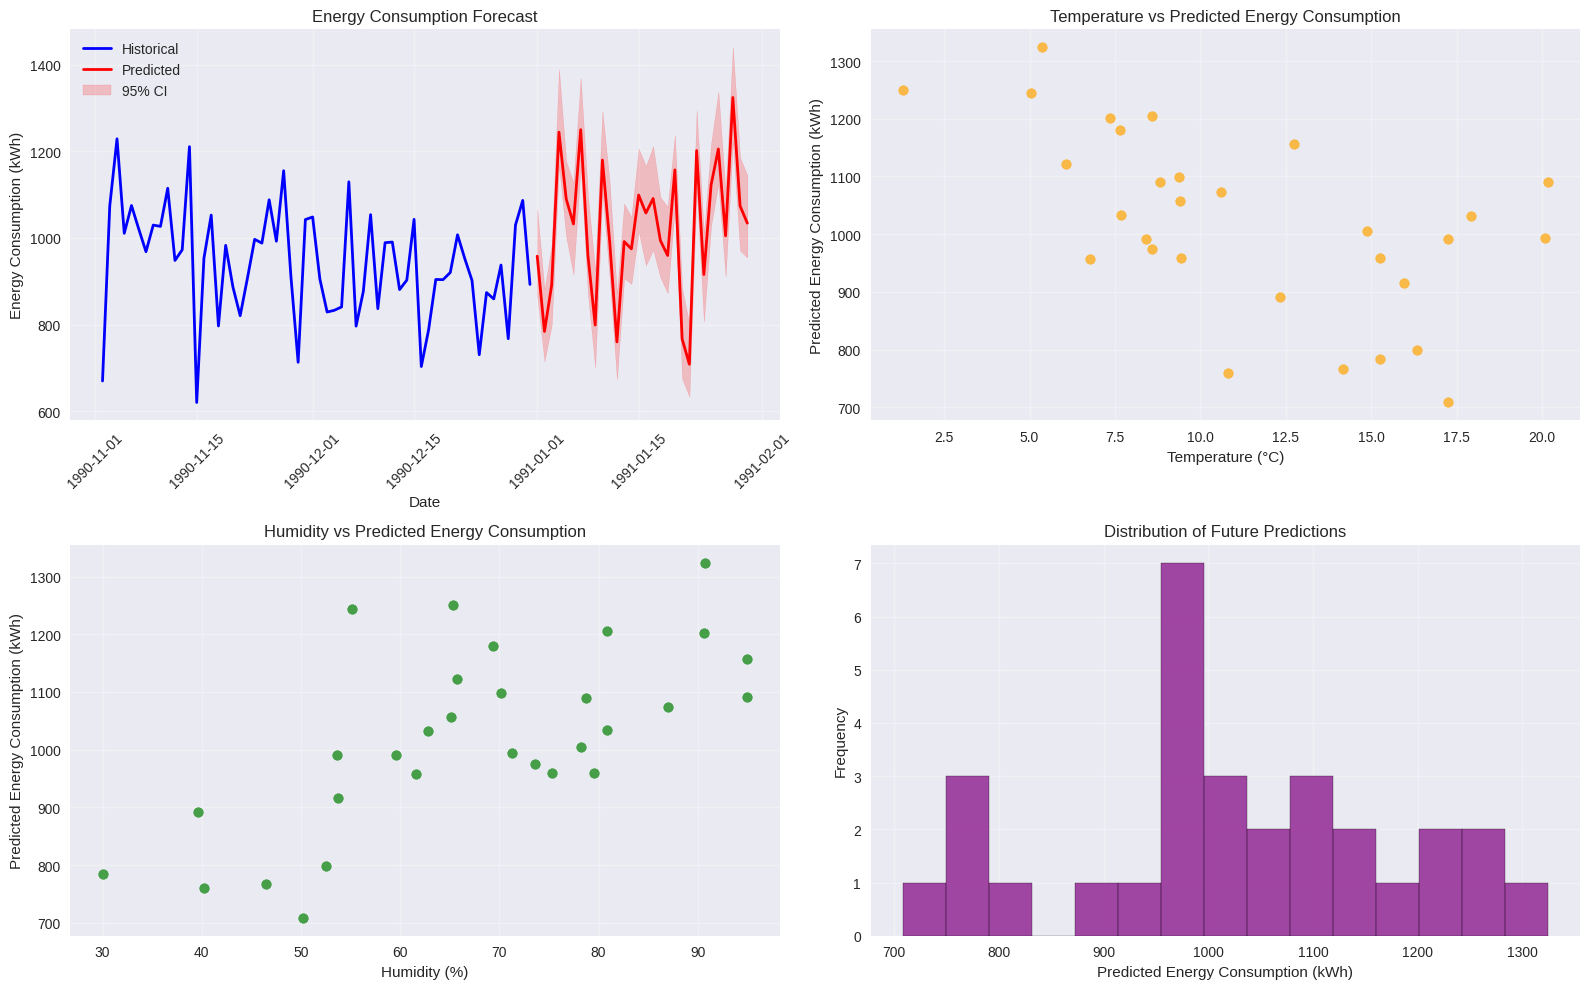

In [22]:
print("\n=== FUTURE PREDICTIONS ===")

last_date = df_features.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30, freq='D')

np.random.seed(123)
future_temp = np.random.normal(df_features['Temperature_C'].mean(),
                              df_features['Temperature_C'].std(), 30)
future_humidity = np.random.normal(df_features['Humidity'].mean(),
                                  df_features['Humidity'].std(), 30).clip(30, 95)
future_wind = np.random.exponential(df_features['Wind_Speed'].mean(), 30).clip(0, 15)
future_solar = np.random.normal(df_features['Solar_Radiation'].mean(),
                               df_features['Solar_Radiation'].std(), 30).clip(0, 800)
future_pressure = np.random.normal(df_features['Pressure'].mean(),
                                  df_features['Pressure'].std(), 30).clip(990, 1030)

future_df = pd.DataFrame({
    'Temperature_C': future_temp,
    'Humidity': future_humidity,
    'Wind_Speed': future_wind,
    'Solar_Radiation': future_solar,
    'Pressure': future_pressure
}, index=future_dates)

future_df['Month'] = future_df.index.month
future_df['Day_of_Year'] = future_df.index.dayofyear
future_df['Quarter'] = future_df.index.quarter
future_df['Week_of_Year'] = future_df.index.isocalendar().week
future_df['Day_of_Week'] = future_df.index.dayofweek
future_df['Is_Weekend'] = (future_df['Day_of_Week'] >= 5).astype(int)

future_df['Season'] = future_df['Month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                             3: 'Spring', 4: 'Spring', 5: 'Spring',
                                             6: 'Summer', 7: 'Summer', 8: 'Summer',
                                             9: 'Autumn', 10: 'Autumn', 11: 'Autumn'})

future_df['Temp_Category'] = pd.cut(future_df['Temperature_C'],
                                   bins=[-np.inf, 5, 15, 25, np.inf],
                                   labels=['Cold', 'Cool', 'Moderate', 'Hot'])

future_df['Temp_Humidity_Interaction'] = future_df['Temperature_C'] * future_df['Humidity']
future_df['Wind_Solar_Interaction'] = future_df['Wind_Speed'] * future_df['Solar_Radiation']
future_df['Pressure_Temp_Interaction'] = future_df['Pressure'] * future_df['Temperature_C']

future_df['Temperature_Squared'] = future_df['Temperature_C'] ** 2
future_df['Humidity_Squared'] = future_df['Humidity'] ** 2
future_df['Wind_Speed_Sqrt'] = np.sqrt(future_df['Wind_Speed'])

recent_temp_ma_7 = df_features['Temperature_C'].tail(7).mean()
recent_temp_ma_30 = df_features['Temperature_C'].tail(30).mean()
recent_energy_ma_7 = df_features['Energy_Consumption'].tail(7).mean()
recent_temp_lag_1 = df_features['Temperature_C'].iloc[-1]
recent_temp_lag_7 = df_features['Temperature_C'].iloc[-7]
recent_energy_lag_1 = df_features['Energy_Consumption'].iloc[-1]

future_df['Temp_MA_7'] = recent_temp_ma_7
future_df['Temp_MA_30'] = recent_temp_ma_30
future_df['Energy_MA_7'] = recent_energy_ma_7
future_df['Temp_Lag_1'] = recent_temp_lag_1
future_df['Temp_Lag_7'] = recent_temp_lag_7
future_df['Energy_Lag_1'] = recent_energy_lag_1

le_season_future = LabelEncoder()
le_season_future.fit(df_features['Season'])
future_df['Season_Encoded'] = le_season_future.transform(future_df['Season'])

le_temp_cat_future = LabelEncoder()
le_temp_cat_future.fit(df_features['Temp_Category'])
future_df['Temp_Category_Encoded'] = le_temp_cat_future.transform(future_df['Temp_Category'])

future_df_aligned = future_df.reindex(columns=feature_columns, fill_value=0)

future_predictions = predict_energy_consumption(future_df_aligned, deployment_package)

future_df['Predicted_Energy_Consumption'] = future_predictions

n_bootstrap = 100
bootstrap_predictions = []
for i in range(n_bootstrap):
    bootstrap_residuals = np.random.choice(test_residuals, size=len(future_predictions), replace=True)
    bootstrap_pred = future_predictions + bootstrap_residuals
    bootstrap_predictions.append(bootstrap_pred)

bootstrap_predictions = np.array(bootstrap_predictions)
future_df['Prediction_Lower_95'] = np.percentile(bootstrap_predictions, 2.5, axis=0)
future_df['Prediction_Upper_95'] = np.percentile(bootstrap_predictions, 97.5, axis=0)
future_df['Prediction_Lower_80'] = np.percentile(bootstrap_predictions, 10, axis=0)
future_df['Prediction_Upper_80'] = np.percentile(bootstrap_predictions, 90, axis=0)

print("Future Energy Consumption Predictions (Next 30 Days):")
print(future_df[['Temperature_C', 'Humidity', 'Predicted_Energy_Consumption',
                'Prediction_Lower_95', 'Prediction_Upper_95']].head(10))

plt.figure(figsize=(16, 10))

historical_recent = df_features.tail(60)
plt.subplot(2, 2, 1)
plt.plot(historical_recent.index, historical_recent['Energy_Consumption'],
         'b-', label='Historical', linewidth=2)
plt.plot(future_df.index, future_df['Predicted_Energy_Consumption'],
         'r-', label='Predicted', linewidth=2)
plt.fill_between(future_df.index, future_df['Prediction_Lower_95'],
                 future_df['Prediction_Upper_95'], alpha=0.2, color='red', label='95% CI')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption Forecast')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.scatter(future_df['Temperature_C'], future_df['Predicted_Energy_Consumption'],
           alpha=0.7, color='orange')
plt.xlabel('Temperature (°C)')
plt.ylabel('Predicted Energy Consumption (kWh)')
plt.title('Temperature vs Predicted Energy Consumption')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.scatter(future_df['Humidity'], future_df['Predicted_Energy_Consumption'],
           alpha=0.7, color='green')
plt.xlabel('Humidity (%)')
plt.ylabel('Predicted Energy Consumption (kWh)')
plt.title('Humidity vs Predicted Energy Consumption')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.hist(future_df['Predicted_Energy_Consumption'], bins=15, alpha=0.7,
         color='purple', edgecolor='black')
plt.xlabel('Predicted Energy Consumption (kWh)')
plt.ylabel('Frequency')
plt.title('Distribution of Future Predictions')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Generate summary statistics

In [23]:
print("\n=== PREDICTION SUMMARY STATISTICS ===")
prediction_stats = {
    'Mean': future_df['Predicted_Energy_Consumption'].mean(),
    'Median': future_df['Predicted_Energy_Consumption'].median(),
    'Std Dev': future_df['Predicted_Energy_Consumption'].std(),
    'Min': future_df['Predicted_Energy_Consumption'].min(),
    'Max': future_df['Predicted_Energy_Consumption'].max(),
    'Range': future_df['Predicted_Energy_Consumption'].max() - future_df['Predicted_Energy_Consumption'].min()
}

for stat, value in prediction_stats.items():
    print(f"{stat}: {value:.2f} kWh")

peak_days = future_df.nlargest(5, 'Predicted_Energy_Consumption')
print(f"\nTop 5 Predicted High Consumption Days:")
display(peak_days[['Temperature_C', 'Humidity', 'Predicted_Energy_Consumption', 'Prediction_Lower_95', 'Prediction_Upper_95']])


print("\n=== ENERGY EFFICIENCY RECOMMENDATIONS ===")
high_consumption_threshold = future_df['Predicted_Energy_Consumption'].quantile(0.8)
high_consumption_days = future_df[future_df['Predicted_Energy_Consumption'] > high_consumption_threshold]

print(f"High consumption days (>{high_consumption_threshold:.2f} kWh): {len(high_consumption_days)} days")
print(f"Average temperature on high consumption days: {high_consumption_days['Temperature_C'].mean():.1f}°C")
print(f"Average humidity on high consumption days: {high_consumption_days['Humidity'].mean():.1f}%")

def create_monitoring_alerts(predictions_df, thresholds):
    alerts = []

    if (predictions_df['Predicted_Energy_Consumption'] > thresholds['high_consumption']).any():
        high_days = predictions_df[predictions_df['Predicted_Energy_Consumption'] > thresholds['high_consumption']]
        alerts.append(f"HIGH CONSUMPTION ALERT: {len(high_days)} days with consumption > {thresholds['high_consumption']:.2f} kWh")

    if (predictions_df['Temperature_C'] > thresholds['high_temp']).any() or (predictions_df['Temperature_C'] < thresholds['low_temp']).any():
        extreme_temp_days = len(predictions_df[(predictions_df['Temperature_C'] > thresholds['high_temp']) |
                                              (predictions_df['Temperature_C'] < thresholds['low_temp'])])
        alerts.append(f"TEMPERATURE EXTREME ALERT: {extreme_temp_days} days with extreme temperatures")

    consecutive_high = 0
    max_consecutive = 0
    for consumption in predictions_df['Predicted_Energy_Consumption']:
        if consumption > thresholds['high_consumption']:
            consecutive_high += 1
            max_consecutive = max(max_consecutive, consecutive_high)
        else:
            consecutive_high = 0

    if max_consecutive >= 3:
        alerts.append(f"SUSTAINED HIGH CONSUMPTION ALERT: {max_consecutive} consecutive days above threshold")

    return alerts

monitoring_thresholds = {
    'high_consumption': df_features['Energy_Consumption'].quantile(0.9),
    'high_temp': df_features['Temperature_C'].quantile(0.95),
    'low_temp': df_features['Temperature_C'].quantile(0.05)
}

alerts = create_monitoring_alerts(future_df, monitoring_thresholds)
print("\n=== MONITORING ALERTS ===")
if alerts:
    for alert in alerts:
        print(f"{alert}")
else:
    print("No alerts detected for the forecast period")

print("\n=== MODEL PERFORMANCE MONITORING ===")
print(f"Model Version: {deployment_package['model_name']}")
print(f"Training R²: {deployment_package['performance_metrics']['R2']:.4f}")
print(f"Training RMSE: {deployment_package['performance_metrics']['RMSE']:.2f}")
print(f"Training MAE: {deployment_package['performance_metrics']['MAE']:.2f}")


=== PREDICTION SUMMARY STATISTICS ===
Mean: 1020.67 kWh
Median: 1018.49 kWh
Std Dev: 157.05 kWh
Min: 708.30 kWh
Max: 1324.26 kWh
Range: 615.96 kWh

Top 5 Predicted High Consumption Days:


,Temperature_C,Humidity,Predicted_Energy_Consumption,Prediction_Lower_95,Prediction_Upper_95
1991-01-28,5.360399,90.754623,1324.261055,1223.240961,1440.611963
1991-01-07,1.296711,65.337068,1249.900650,1168.524908,1370.131026
1991-01-04,5.044367,55.142380,1244.094940,1168.013684,1389.262770
1991-01-26,8.580933,80.808779,1205.333014,1125.247046,1337.581477
1991-01-23,7.367191,90.592518,1201.670352,1114.257647,1294.622021



=== ENERGY EFFICIENCY RECOMMENDATIONS ===
High consumption days (>1161.59 kWh): 6 days
Average temperature on high consumption days: 5.9°C
Average humidity on high consumption days: 75.3%

=== MONITORING ALERTS ===
HIGH CONSUMPTION ALERT: 5 days with consumption > 1200.16 kWh
TEMPERATURE EXTREME ALERT: 4 days with extreme temperatures

=== MODEL PERFORMANCE MONITORING ===
Model Version: GradientBoosting
Training R²: 0.8741
Training RMSE: 52.47
Training MAE: 41.26


# Feature drift detection for future data


In [24]:
def detect_feature_drift(historical_data, future_data, threshold=0.1):
    drift_detected = {}

    numeric_features = ['Temperature_C', 'Humidity', 'Wind_Speed', 'Solar_Radiation', 'Pressure']

    for feature in numeric_features:
        if feature in historical_data.columns and feature in future_data.columns:
            hist_mean = historical_data[feature].mean()
            hist_std = historical_data[feature].std()

            future_mean = future_data[feature].mean()
            future_std = future_data[feature].std()

            mean_drift = abs(future_mean - hist_mean) / hist_std
            std_drift = abs(future_std - hist_std) / hist_std

            drift_detected[feature] = {
                'mean_drift': mean_drift,
                'std_drift': std_drift,
                'drift_flag': mean_drift > threshold or std_drift > threshold
            }

    return drift_detected

drift_analysis = detect_feature_drift(df_features, future_df)
print("\n=== FEATURE DRIFT ANALYSIS ===")
for feature, drift_info in drift_analysis.items():
    status = "DRIFT DETECTED" if drift_info['drift_flag'] else "No drift"
    print(f"{feature}: {status} (Mean drift: {drift_info['mean_drift']:.3f}, Std drift: {drift_info['std_drift']:.3f})")

# Export predictions to CSV
future_df_export = future_df[['Temperature_C', 'Humidity', 'Wind_Speed', 'Solar_Radiation',
                             'Pressure', 'Predicted_Energy_Consumption', 'Prediction_Lower_95',
                             'Prediction_Upper_95']].copy()
future_df_export.to_csv('Exported_Data/future_energy_predictions.csv')
print("\nFuture predictions exported to 'future_energy_predictions.csv'")

model_documentation = f"""
# Energy Consumption Prediction Model Documentation

## Model Information
- **Model Type**: {deployment_package['model_name']}
- **Scaler**: {deployment_package['scaler_name']}

## Performance Metrics
- **R² Score**: {deployment_package['performance_metrics']['R2']:.4f}
- **RMSE**: {deployment_package['performance_metrics']['RMSE']:.2f} kWh
- **MAE**: {deployment_package['performance_metrics']['MAE']:.2f} kWh
- **MAPE**: {deployment_package['performance_metrics']['MAPE']:.4f}

## Top 5 Most Important Features
"""

for i, (feature, stats) in enumerate(list(deployment_package['feature_importance'].items())[:5]):
    model_documentation += f"{i+1}. {feature}: {stats['mean_importance']:.4f}\n"

model_documentation += f"""
## Prediction Intervals
- 95% Confidence Interval: Available
- 80% Confidence Interval: Available
- Bootstrap samples: 100

## Model Limitations
- Performance may degrade with significant weather pattern changes
- Requires regular retraining for optimal performance

## Usage Instructions
1. Load model: `joblib.load('energy_consumption_model.pkl')`
2. Prepare data with required features: {len(deployment_package['feature_columns'])} features
3. Use predict_energy_consumption() function for predictions
4. Monitor for feature drift and model performance degradation
"""

with open('Exported_Data/model_documentation.txt', 'w') as f:
    f.write(model_documentation)

print("Model documentation created: 'model_documentation.txt'")
print("\n=== DEPLOYMENT PACKAGE COMPLETE ===")
print("Files created:")
print("- energy_consumption_model.pkl (Model package)")
print("- future_energy_predictions.csv (30-day predictions)")
print("- model_documentation.txt (Documentation)")
print("\nModel is ready for production deployment!")


=== FEATURE DRIFT ANALYSIS ===
Temperature_C: DRIFT DETECTED (Mean drift: 0.045, Std drift: 0.187)
Humidity: DRIFT DETECTED (Mean drift: 0.136, Std drift: 0.172)
Wind_Speed: No drift (Mean drift: 0.012, Std drift: 0.067)
Solar_Radiation: DRIFT DETECTED (Mean drift: 0.066, Std drift: 0.106)
Pressure: No drift (Mean drift: 0.065, Std drift: 0.049)

Future predictions exported to 'future_energy_predictions.csv'
Model documentation created: 'model_documentation.txt'

=== DEPLOYMENT PACKAGE COMPLETE ===
Files created:
- energy_consumption_model.pkl (Model package)
- future_energy_predictions.csv (30-day predictions)
- model_documentation.txt (Documentation)

Model is ready for production deployment!


# Processing to Export

In [25]:
import json
import zipfile
from pathlib import Path
import pickle
import csv

os.makedirs('Exported_Data', exist_ok=True)
export_dir = "Exported_Data"
feature_stability = {}

all_features_list = list(all_features)
for feature in all_features_list:
    appearances = 0
    for model_results in list(importance_results.values()) + list(perm_importance_results.values()):
         if feature in model_results:
             appearances += 1

    stability_score = appearances / (len(importance_results) + len(perm_importance_results)) if (len(importance_results) + len(perm_importance_results)) > 0 else 0

    cv_importance_std = feature_importance_summary.get(feature, {}).get('std_importance', 0)

    cv_importance = (cv_importance_std / feature_importance_summary.get(feature, {}).get('mean_importance', 1e-9)) if feature_importance_summary.get(feature, {}).get('mean_importance', 1e-9) != 0 else np.inf

    feature_stability[feature] = {
        'appearances': appearances,
        'stability_score': stability_score,
        'cv_importance': cv_importance
    }

stable_features = sorted(feature_stability.items(),
                        key=lambda x: (x[1]['stability_score'], -x[1]['cv_importance']), reverse=True)

# Export to CSV code

In [26]:
try:
    performance_df.to_csv('Exported_Data/model_performance_metrics.csv')
    print("Model performance metrics exported")
except Exception as e:
    print(f"Warning: Could not export model performance metrics - {e}")

try:
    evaluation_results_df = pd.DataFrame(evaluation_results).T
    evaluation_results_df.to_csv('Exported_Data/detailed_evaluation_results.csv')
    print("Detailed evaluation results exported")
except Exception as e:
    print(f"Warning: Could not export evaluation results - {e}")

try:
    cv_scores_df = pd.DataFrame({model: scores['scores'] for model, scores in cv_scores.items()})
    cv_scores_df.to_csv('Exported_Data/cross_validation_scores.csv')
    print("Cross-validation scores exported")
except Exception as e:
    print(f"Warning: Could not export CV scores - {e}")

try:
    feature_importance_df = pd.DataFrame([(f[0], f[1]['mean_importance'], f[1]['std_importance'], f[1]['count'])
                                         for f in sorted_features],
                                        columns=['Feature', 'Mean_Importance', 'Std_Importance', 'Count'])
    feature_importance_df.to_csv('Exported_Data/feature_importance_ranking.csv', index=False)
    print("Feature importance ranking exported")
except Exception as e:
    print(f"Warning: Could not export feature importance - {e}")

try:
    correlation_results_df = pd.DataFrame([(f[0], f[1]['correlation'], f[1]['p_value'])
                                          for f in sorted_corr],
                                         columns=['Feature', 'Correlation', 'P_Value'])
    correlation_results_df.to_csv('Exported_Data/feature_target_correlations.csv', index=False)
    print("Feature correlations exported")
except Exception as e:
    print(f"Warning: Could not export feature correlations - {e}")

try:
    ensemble_results_df = pd.DataFrame({
        'Method': ['VotingRegressor', 'StackingRegressor', 'WeightedEnsemble'],
        'MSE': [ensemble_results['VotingRegressor']['MSE'],
                ensemble_results['StackingRegressor']['MSE'],
                ensemble_results['WeightedEnsemble']['MSE']],
        'R2': [ensemble_results['VotingRegressor']['R2'],
               ensemble_results['StackingRegressor']['R2'],
               ensemble_results['WeightedEnsemble']['R2']]
    })
    ensemble_results_df.to_csv('Exported_Data/ensemble_results.csv', index=False)
    print("Ensemble results exported")
except Exception as e:
    print(f"Warning: Could not export ensemble results - {e}")

try:
    future_df_export = future_df[['Temperature_C', 'Humidity', 'Wind_Speed', 'Solar_Radiation',
                                 'Pressure', 'Predicted_Energy_Consumption', 'Prediction_Lower_95',
                                 'Prediction_Upper_95']].copy()
    future_df_export.to_csv('Exported_Data/future_predictions.csv')
    print("Future predictions exported")
except Exception as e:
    print(f"Warning: Could not export future predictions - {e}")

try:
    residuals_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_test_pred,
        'Residuals': test_residuals
    })
    residuals_df.to_csv('Exported_Data/residual_analysis.csv', index=False)
    print("Residual analysis exported")
except Exception as e:
    print(f"Warning: Could not export residual analysis - {e}")

try:
    seasonal_stats.to_csv('Exported_Data/seasonal_statistics.csv')
    print("Seasonal statistics exported")
except Exception as e:
    print(f"Warning: Could not export seasonal statistics - {e}")

try:
    best_params_df = pd.DataFrame([(model, str(params)) for model, params in best_params.items()],
                                 columns=['Model', 'Best_Parameters'])
    best_params_df.to_csv('Exported_Data/best_hyperparameters.csv', index=False)
    print("Best hyperparameters exported")
except Exception as e:
    print(f"Warning: Could not export best hyperparameters - {e}")

try:
    drift_analysis_df = pd.DataFrame([(feature, info['mean_drift'], info['std_drift'], info['drift_flag'])
                                     for feature, info in drift_analysis.items()],
                                    columns=['Feature', 'Mean_Drift', 'Std_Drift', 'Drift_Flag'])
    drift_analysis_df.to_csv('Exported_Data/feature_drift_analysis.csv', index=False)
    print("Feature drift analysis exported")
except Exception as e:
    print(f"Warning: Could not export drift analysis - {e}")

try:
    df_features.to_csv('Exported_Data/processed_dataset.csv')
    print("Processed dataset exported")
except Exception as e:
    print(f"Warning: Could not export processed dataset - {e}")

try:
    correlation_matrix.to_csv('Exported_Data/correlation_matrix.csv')
    print("Correlation matrix exported")
except Exception as e:
    print(f"Warning: Could not export correlation matrix - {e}")

try:
    X_train.to_csv('Exported_Data/training_features.csv')
    pd.DataFrame({'Energy_Consumption': y_train}).to_csv('Exported_Data/training_targets.csv')
    print("Training data exported")
except Exception as e:
    print(f"Warning: Could not export training data - {e}")

try:
    X_test.to_csv('Exported_Data/test_features.csv')
    pd.DataFrame({'Energy_Consumption': y_test}).to_csv('Exported_Data/test_targets.csv')
    print("Test data exported")
except Exception as e:
    print(f"Warning: Could not export test data - {e}")

try:
    cv_detailed_df = pd.DataFrame({model: results['MSE']['scores'] for model, results in cv_detailed_results.items()})
    cv_detailed_df.to_csv('Exported_Data/detailed_cross_validation.csv')
    print("Detailed cross-validation exported")
except Exception as e:
    print(f"Warning: Could not export detailed CV results - {e}")

try:
    feature_stability_df = pd.DataFrame([(f[0], f[1]['appearances'], f[1]['stability_score'], f[1]['cv_importance'])
                                        for f in stable_features],
                                       columns=['Feature', 'Appearances', 'Stability_Score', 'CV_Importance'])
    feature_stability_df.to_csv('Exported_Data/feature_stability_analysis.csv', index=False)
    print("Feature stability analysis exported")
except Exception as e:
    print(f"Warning: Could not export feature stability - {e}")

try:
    predictions_comparison = pd.DataFrame({f'{model}_predictions': pred for model, pred in predictions.items()})
    predictions_comparison['actual'] = y_test.values
    predictions_comparison.to_csv('Exported_Data/model_predictions_comparison.csv', index=False)
    print("Model predictions comparison exported")
except Exception as e:
    print(f"Warning: Could not export predictions comparison - {e}")

try:
    scaler_comparison = pd.DataFrame({scaler_name: pd.Series(X_train_scaled[scaler_name][:, 0])
                                     for scaler_name in scalers.keys()})
    scaler_comparison.to_csv('Exported_Data/scaler_comparison_sample.csv', index=False)
    print("Scaler comparison exported")
except Exception as e:
    print(f"Warning: Could not export scaler comparison - {e}")

try:
    monthly_patterns = df_features.groupby('Month')['Energy_Consumption'].agg(['mean', 'std', 'min', 'max'])
    monthly_patterns.to_csv('Exported_Data/monthly_consumption_patterns.csv')
    print("Monthly patterns exported")
except Exception as e:
    print(f"Warning: Could not export monthly patterns - {e}")

try:
    daily_patterns = df_features.groupby('Day_of_Week')['Energy_Consumption'].agg(['mean', 'std', 'min', 'max'])
    daily_patterns.to_csv('Exported_Data/daily_consumption_patterns.csv')
    print("Daily patterns exported")
except Exception as e:
    print(f"Warning: Could not export daily patterns - {e}")

try:
    weather_impact = df_features[['Temperature_C', 'Humidity', 'Wind_Speed', 'Solar_Radiation', 'Pressure', 'Energy_Consumption']].corr()
    weather_impact.to_csv('Exported_Data/weather_impact_correlations.csv')
    print("Weather impact correlations exported")
except Exception as e:
    print(f"Warning: Could not export weather correlations - {e}")

try:
    feature_engineering_summary = pd.DataFrame({
        'Original_Features': ['Temperature_C', 'Humidity', 'Wind_Speed', 'Solar_Radiation', 'Pressure'],
        'Feature_Count': [1, 1, 1, 1, 1],
        'Engineered_Features': [
            'Temp_MA_7, Temp_MA_30, Temperature_Squared, Temp_Lag_1, Temp_Lag_7',
            'Humidity_Squared, Temp_Humidity_Interaction',
            'Wind_Speed_Sqrt, Wind_Solar_Interaction',
            'Wind_Solar_Interaction',
            'Pressure_Temp_Interaction'
        ]
    })
    feature_engineering_summary.to_csv('Exported_Data/feature_engineering_summary.csv', index=False)
    print("Feature engineering summary exported")
except Exception as e:
    print(f"Warning: Could not export feature engineering summary - {e}")

try:
    outliers_analysis = df_features[df_features['Energy_Consumption'] > df_features['Energy_Consumption'].quantile(0.99)]
    outliers_analysis.to_csv('Exported_Data/outliers_analysis.csv')
    print("Outliers analysis exported")
except Exception as e:
    print(f"Warning: Could not export outliers analysis - {e}")

try:
    training_metadata = pd.DataFrame({
        'Metric': ['Training_Size', 'Test_Size', 'Feature_Count', 'Best_Model', 'Best_R2', 'Best_RMSE'],
        'Value': [len(X_train), len(X_test), len(feature_columns), best_model_name,
                  evaluation_results[best_model_name]['R2'], evaluation_results[best_model_name]['RMSE']]
    })
    training_metadata.to_csv('Exported_Data/training_metadata.csv', index=False)
    print("Training metadata exported")
except Exception as e:
    print(f"Warning: Could not export training metadata - {e}")

Model performance metrics exported
Detailed evaluation results exported
Cross-validation scores exported
Feature importance ranking exported
Feature correlations exported
Ensemble results exported
Future predictions exported
Residual analysis exported
Seasonal statistics exported
Best hyperparameters exported
Feature drift analysis exported
Processed dataset exported
Correlation matrix exported
Training data exported
Test data exported
Detailed cross-validation exported
Feature stability analysis exported
Model predictions comparison exported
Scaler comparison exported
Monthly patterns exported
Daily patterns exported
Weather impact correlations exported
Feature engineering summary exported
Outliers analysis exported
Training metadata exported


# Export to txt code

In [27]:
try:
    with open('Exported_Data/model_summary_report.txt', 'w') as f:
        f.write("ENERGY CONSUMPTION PREDICTION MODEL REPORT\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Best Model: {best_model_name}\n")
        f.write(f"R² Score: {evaluation_results[best_model_name]['R2']:.4f}\n")
        f.write(f"RMSE: {evaluation_results[best_model_name]['RMSE']:.2f} kWh\n")
        f.write(f"MAE: {evaluation_results[best_model_name]['MAE']:.2f} kWh\n")
        f.write(f"MAPE: {evaluation_results[best_model_name]['MAPE']:.4f}\n\n")
        f.write("TOP 10 IMPORTANT FEATURES:\n")
        f.write("-" * 30 + "\n")
        for i, (feature, stats) in enumerate(sorted_features[:10]):
            f.write(f"{i+1:2d}. {feature:25s}: {stats['mean_importance']:.4f}\n")
    print("Model summary report exported")
except Exception as e:
    print(f"Warning: Could not export model summary - {e}")

try:
    with open('Exported_Data/feature_correlations.txt', 'w') as f:
        f.write("FEATURE-TARGET CORRELATIONS\n")
        f.write("=" * 30 + "\n")
        for i, (feature, stats) in enumerate(sorted_corr[:15]):
            f.write(f"{i+1:2d}. {feature:25s}: {stats['correlation']:6.4f} (p={stats['p_value']:.4e})\n")
    print("Feature correlations report exported")
except Exception as e:
    print(f"Warning: Could not export feature correlations report - {e}")

try:
    with open('Exported_Data/model_evaluation_summary.txt', 'w') as f:
        f.write("MODEL EVALUATION SUMMARY\n")
        f.write("=" * 25 + "\n")
        for model_name, metrics in evaluation_results.items():
            f.write(f"\n{model_name}:\n")
            f.write(f"  MSE: {metrics['MSE']:.2f}\n")
            f.write(f"  RMSE: {metrics['RMSE']:.2f}\n")
            f.write(f"  MAE: {metrics['MAE']:.2f}\n")
            f.write(f"  R²: {metrics['R2']:.4f}\n")
            f.write(f"  MAPE: {metrics['MAPE']:.4f}\n")
    print("Model evaluation summary exported")
except Exception as e:
    print(f"Warning: Could not export model evaluation summary - {e}")

try:
    with open('Exported_Data/ensemble_analysis.txt', 'w') as f:
        f.write("ENSEMBLE METHODS ANALYSIS\n")
        f.write("=" * 25 + "\n")
        for method, results in ensemble_results.items():
            f.write(f"\n{method}:\n")
            f.write(f"  MSE: {results['MSE']:.2f}\n")
            f.write(f"  R²: {results['R2']:.4f}\n")
    print("Ensemble analysis exported")
except Exception as e:
    print(f"Warning: Could not export ensemble analysis - {e}")

try:
    with open('Exported_Data/seasonal_insights.txt', 'w') as f:
        f.write("SEASONAL CONSUMPTION INSIGHTS\n")
        f.write("=" * 30 + "\n")

        if hasattr(seasonal_stats, 'columns') and isinstance(seasonal_stats.columns, pd.MultiIndex):
            for season in seasonal_stats.index:
                f.write(f"\n{season}:\n")
                f.write(f"  Mean: {seasonal_stats.loc[season, ('Energy_Consumption', 'mean')]:.2f} kWh\n")
                f.write(f"  Std: {seasonal_stats.loc[season, ('Energy_Consumption', 'std')]:.2f} kWh\n")
                f.write(f"  Count: {seasonal_stats.loc[season, ('Energy_Consumption', 'count')]} days\n")
        else:
            for season in seasonal_stats.index:
                f.write(f"\n{season}:\n")
                if 'mean' in seasonal_stats.columns:
                    f.write(f"  Mean: {seasonal_stats.loc[season, 'mean']:.2f} kWh\n")
                if 'std' in seasonal_stats.columns:
                    f.write(f"  Std: {seasonal_stats.loc[season, 'std']:.2f} kWh\n")
                if 'count' in seasonal_stats.columns:
                    f.write(f"  Count: {seasonal_stats.loc[season, 'count']} days\n")
    print("Seasonal insights exported")
except Exception as e:
    print(f"Warning: Could not export seasonal insights - {e}")

try:
    with open('Exported_Data/feature_engineering_log.txt', 'w') as f:
        f.write("FEATURE ENGINEERING LOG\n")
        f.write("=" * 25 + "\n")
        f.write(f"Original Features: 5\n")
        f.write(f"Total Features After Engineering: {len(feature_columns)}\n")
        f.write(f"Time-based Features: Month, Day_of_Year, Quarter, Week_of_Year, Day_of_Week, Is_Weekend\n")
        f.write(f"Interaction Features: Temp_Humidity, Wind_Solar, Pressure_Temp\n")
        f.write(f"Polynomial Features: Temperature_Squared, Humidity_Squared\n")
        f.write(f"Lag Features: Temp_Lag_1, Temp_Lag_7, Energy_Lag_1\n")
        f.write(f"Moving Average Features: Temp_MA_7, Temp_MA_30, Energy_MA_7\n")
    print("Feature engineering log exported")
except Exception as e:
    print(f"Warning: Could not export feature engineering log - {e}")

try:
    with open('Exported_Data/hyperparameter_optimization.txt', 'w') as f:
        f.write("HYPERPARAMETER OPTIMIZATION RESULTS\n")
        f.write("=" * 35 + "\n")
        for model_name, params in best_params.items():
            f.write(f"\n{model_name}:\n")
            if params:
                for param, value in params.items():
                    f.write(f"  {param}: {value}\n")
            else:
                f.write("  No hyperparameters optimized\n")
    print("Hyperparameter optimization results exported")
except Exception as e:
    print(f"Warning: Could not export hyperparameter results - {e}")

try:
    with open('Exported_Data/data_quality_report.txt', 'w') as f:
        f.write("DATA QUALITY REPORT\n")
        f.write("=" * 20 + "\n")
        f.write(f"Dataset Shape: {df_features.shape}\n")
        f.write(f"Date Range: {df_features.index.min()} to {df_features.index.max()}\n")
        f.write(f"Missing Values: {df_features.isnull().sum().sum()}\n")
        f.write(f"Duplicate Rows: {df_features.duplicated().sum()}\n")
        f.write(f"Energy Consumption Range: {df_features['Energy_Consumption'].min():.2f} - {df_features['Energy_Consumption'].max():.2f} kWh\n")
    print("Data quality report exported")
except Exception as e:
    print(f"Warning: Could not export data quality report - {e}")

try:
    with open('Exported_Data/prediction_summary.txt', 'w') as f:
        f.write("FUTURE PREDICTIONS SUMMARY\n")
        f.write("=" * 25 + "\n")
        f.write(f"Prediction Period: 30 days\n")
        f.write(f"Mean Prediction: {future_df['Predicted_Energy_Consumption'].mean():.2f} kWh\n")
        f.write(f"Prediction Range: {future_df['Predicted_Energy_Consumption'].min():.2f} - {future_df['Predicted_Energy_Consumption'].max():.2f} kWh\n")
        f.write(f"High Consumption Days (>90th percentile): {len(future_df[future_df['Predicted_Energy_Consumption'] > future_df['Predicted_Energy_Consumption'].quantile(0.9)])}\n")
    print("Prediction summary exported")
except Exception as e:
    print(f"Warning: Could not export prediction summary - {e}")

Model summary report exported
Feature correlations report exported
Model evaluation summary exported
Ensemble analysis exported
Seasonal insights exported
Feature engineering log exported
Hyperparameter optimization results exported
Data quality report exported
Prediction summary exported


# Export to json

In [28]:
def export_model_performance_json():
    performance_summary = {
        "model_performance": {},
        "cross_validation_scores": {},
        "feature_importance_summary": {},
        "ensemble_results": {},
        "statistical_tests": {}
    }

    for model_name, results in evaluation_results.items():
        performance_summary["model_performance"][model_name] = {
            "MSE": float(results["MSE"]),
            "RMSE": float(results["RMSE"]),
            "MAE": float(results["MAE"]),
            "R2": float(results["R2"]),
            "MAPE": float(results["MAPE"]),
            "CV_MSE_mean": float(results["CV_MSE_mean"]),
            "CV_MSE_std": float(results["CV_MSE_std"])
        }

    for model_name, cv_data in cv_detailed_results.items():
        performance_summary["cross_validation_scores"][model_name] = {
            "MSE_scores": [float(x) for x in cv_data["MSE"]["scores"]],
            "R2_scores": [float(x) for x in cv_data["R2"]["scores"]],
            "MAE_scores": [float(x) for x in cv_data["MAE"]["scores"]]
        }

    for feature, stats in feature_importance_summary.items():
        performance_summary["feature_importance_summary"][feature] = {
            "mean_importance": float(stats["mean_importance"]),
            "std_importance": float(stats["std_importance"]),
            "count": int(stats["count"])
        }

    for method, results in ensemble_results.items():
        performance_summary["ensemble_results"][method] = {
            "MSE": float(results["MSE"]),
            "R2": float(results["R2"])
        }

    with open(f"{export_dir}/model_performance.json", "w") as f:
        json.dump(performance_summary, f, indent=4)
export_model_performance_json()
print("Model performance json exported")

def export_dataset_analysis_json():
    dataset_analysis = {
        "dataset_overview": {
            "shape": list(df_features.shape),
            "date_range": {
                "start": str(df_features.index.min()),
                "end": str(df_features.index.max())
            },
            "missing_values": int(df_features.isnull().sum().sum())
        },
        "statistical_summary": {},
        "correlation_matrix": {},
        "seasonal_analysis": {},
        "feature_correlations": {}
    }

    for column in df_features.select_dtypes(include=[np.number]).columns:
        dataset_analysis["statistical_summary"][column] = {
            "mean": float(df_features[column].mean()),
            "std": float(df_features[column].std()),
            "min": float(df_features[column].min()),
            "max": float(df_features[column].max()),
            "median": float(df_features[column].median())
        }

    corr_matrix = df_features.select_dtypes(include=[np.number]).corr()
    for col1 in corr_matrix.columns:
        dataset_analysis["correlation_matrix"][col1] = {}
        for col2 in corr_matrix.columns:
            dataset_analysis["correlation_matrix"][col1][col2] = float(corr_matrix.loc[col1, col2])

    seasonal_stats = df_features.groupby('Season')['Energy_Consumption'].agg(['mean', 'std', 'count'])
    for season in seasonal_stats.index:
        dataset_analysis["seasonal_analysis"][season] = {
            "mean_consumption": float(seasonal_stats.loc[season, 'mean']),
            "std_consumption": float(seasonal_stats.loc[season, 'std']),
            "count": int(seasonal_stats.loc[season, 'count'])
        }

    for feature, stats in feature_target_corr.items():
        dataset_analysis["feature_correlations"][feature] = {
            "correlation": float(stats["correlation"]),
            "p_value": float(stats["p_value"])
        }

    with open(f"{export_dir}/dataset_analysis.json", "w") as f:
        json.dump(dataset_analysis, f, indent=4)
export_dataset_analysis_json()
print("Dataset analysis json exported")

def export_predictions_json():
    predictions_data = {
        "future_predictions": {},
        "prediction_statistics": {},
        "alerts": alerts,
        "drift_analysis": {}
    }

    for idx, row in future_df.iterrows():
        predictions_data["future_predictions"][str(idx.date())] = {
            "temperature": float(row["Temperature_C"]),
            "humidity": float(row["Humidity"]),
            "wind_speed": float(row["Wind_Speed"]),
            "solar_radiation": float(row["Solar_Radiation"]),
            "pressure": float(row["Pressure"]),
            "predicted_consumption": float(row["Predicted_Energy_Consumption"]),
            "lower_95": float(row["Prediction_Lower_95"]),
            "upper_95": float(row["Prediction_Upper_95"]),
            "lower_80": float(row["Prediction_Lower_80"]),
            "upper_80": float(row["Prediction_Upper_80"])
        }

    predictions_data["prediction_statistics"] = {k: float(v) for k, v in prediction_stats.items()}

    for feature, drift_info in drift_analysis.items():
        predictions_data["drift_analysis"][feature] = {
            "mean_drift": float(drift_info["mean_drift"]),
            "std_drift": float(drift_info["std_drift"]),
            "drift_flag": bool(drift_info["drift_flag"])
        }

    with open(f"{export_dir}/predictions.json", "w") as f:
        json.dump(predictions_data, f, indent=4)
export_predictions_json()
print("Predictions json exported")

def export_model_config_json():
    model_config = {
        "best_model": {
            "name": best_model_name,
            "scaler": best_scaler_name,
            "parameters": best_params.get(best_model_name, {}),
            "feature_count": len(feature_columns)
        },
        "feature_engineering": {
            "original_features": ["Temperature_C", "Humidity", "Wind_Speed", "Solar_Radiation", "Pressure"],
            "engineered_features": feature_columns,
            "interaction_features": [
                "Temp_Humidity_Interaction",
                "Wind_Solar_Interaction",
                "Pressure_Temp_Interaction"
            ],
            "polynomial_features": [
                "Temperature_Squared",
                "Humidity_Squared",
                "Wind_Speed_Sqrt"
            ],
            "temporal_features": [
                "Month", "Day_of_Year", "Quarter",
                "Week_of_Year", "Day_of_Week", "Is_Weekend"
            ],
            "lag_features": [
                "Temp_Lag_1", "Temp_Lag_7",
                "Energy_Lag_1"
            ],
            "moving_averages": [
                "Temp_MA_7", "Temp_MA_30", "Energy_MA_7"
            ]
        },
        "model_hyperparameters": best_params,
        "scaler_mapping": scaler_mapping,
        "training_configuration": {
            "test_size": 0.2,
            "random_state": 42,
            "cv_folds": 5,
            "bootstrap_samples": 100
        }
    }

    with open(f"{export_dir}/model_config.json", "w") as f:
        json.dump(model_config, f, indent=4)
export_model_config_json()
print("Model config json exported")

Model performance json exported
Dataset analysis json exported
Predictions json exported
Model config json exported


# Export to HTML

In [29]:
def create_model_performance_html():
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Energy Consumption Model Performance Report</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 40px; background-color: #f5f5f5; }}
            .container {{ max-width: 1200px; margin: 0 auto; background: white; padding: 30px; border-radius: 10px; }}
            h1 {{ color: #2c3e50; text-align: center; border-bottom: 3px solid #3498db; padding-bottom: 10px; }}
            h2 {{ color: #34495e; margin-top: 30px; }}
            table {{ width: 100%; border-collapse: collapse; margin: 20px 0; }}
            th, td {{ border: 1px solid #ddd; padding: 12px; text-align: center; }}
            th {{ background-color: #3498db; color: white; }}
            tr:nth-child(even) {{ background-color: #f2f2f2; }}
            .metric {{ background-color: #ecf0f1; padding: 15px; margin: 10px; border-radius: 5px; }}
            .best {{ background-color: #d5f4e6; }}
            .summary {{ background-color: #e8f4fd; padding: 20px; border-radius: 8px; margin: 20px 0; }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Energy Consumption Prediction Model Performance Report</h1>

            <div class="summary">
                <h2>Executive Summary</h2>
                <p><strong>Best Model:</strong> {best_model_name}</p>
                <p><strong>R² Score:</strong> {evaluation_results[best_model_name]['R2']:.4f}</p>
                <p><strong>RMSE:</strong> {evaluation_results[best_model_name]['RMSE']:.2f} kWh</p>
                <p><strong>MAE:</strong> {evaluation_results[best_model_name]['MAE']:.2f} kWh</p>
            </div>

            <h2>Model Comparison</h2>
            <table>
                <tr>
                    <th>Model</th>
                    <th>R² Score</th>
                    <th>RMSE</th>
                    <th>MAE</th>
                    <th>MAPE</th>
                </tr>
    """

    for model_name, results in sorted(evaluation_results.items(), key=lambda x: x[1]['R2'], reverse=True):
        css_class = 'best' if model_name == best_model_name else ''
        html_content += f"""
                <tr class="{css_class}">
                    <td><strong>{model_name}</strong></td>
                    <td>{results['R2']:.4f}</td>
                    <td>{results['RMSE']:.2f}</td>
                    <td>{results['MAE']:.2f}</td>
                    <td>{results['MAPE']:.4f}</td>
                </tr>
        """

    html_content += """
            </table>

            <h2>Feature Importance Analysis</h2>
            <table>
                <tr>
                    <th>Rank</th>
                    <th>Feature</th>
                    <th>Importance Score</th>
                    <th>Standard Deviation</th>
                </tr>
    """

    for i, (feature, stats) in enumerate(sorted_features[:15]):
        html_content += f"""
                <tr>
                    <td>{i+1}</td>
                    <td>{feature}</td>
                    <td>{stats['mean_importance']:.4f}</td>
                    <td>{stats['std_importance']:.4f}</td>
                </tr>
        """

    html_content += """
            </table>
        </div>
    </body>
    </html>
    """

    with open(f"{export_dir}/model_performance_report.html", "w") as f:
        f.write(html_content)
create_model_performance_html()
print("Model performance report exported")

Model performance report exported


In [30]:
def create_dataset_analysis_html():
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Dataset Analysis Report</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 40px; background-color: #f8f9fa; }}
            .container {{ max-width: 1200px; margin: 0 auto; background: white; padding: 30px; border-radius: 10px; }}
            h1 {{ color: #2c3e50; text-align: center; border-bottom: 3px solid #e74c3c; padding-bottom: 10px; }}
            h2 {{ color: #34495e; margin-top: 30px; }}
            table {{ width: 100%; border-collapse: collapse; margin: 20px 0; }}
            th, td {{ border: 1px solid #ddd; padding: 12px; text-align: center; }}
            th {{ background-color: #e74c3c; color: white; }}
            tr:nth-child(even) {{ background-color: #f2f2f2; }}
            .info-box {{ background-color: #fff3cd; padding: 15px; border-radius: 5px; margin: 15px 0; }}
            .stat-box {{ display: inline-block; background-color: #e8f4fd; padding: 15px; margin: 10px; border-radius: 5px; }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Energy Consumption Dataset Analysis</h1>

            <div class="info-box">
                <h2>Dataset Overview</h2>
                <p><strong>Dataset Shape:</strong> {df_features.shape[0]} rows × {df_features.shape[1]} columns</p>
                <p><strong>Missing Values:</strong> {df_features.isnull().sum().sum()}</p>
            </div>

            <h2>Statistical Summary</h2>
            <table>
                <tr>
                    <th>Feature</th>
                    <th>Mean</th>
                    <th>Std Dev</th>
                    <th>Min</th>
                    <th>Max</th>
                    <th>Median</th>
                </tr>
    """

    key_features = ['Energy_Consumption', 'Temperature_C', 'Humidity', 'Wind_Speed', 'Solar_Radiation', 'Pressure']
    for feature in key_features:
        if feature in df_features.columns:
            stats = df_features[feature].describe()
            html_content += f"""
                    <tr>
                        <td><strong>{feature}</strong></td>
                        <td>{stats['mean']:.2f}</td>
                        <td>{stats['std']:.2f}</td>
                        <td>{stats['min']:.2f}</td>
                        <td>{stats['max']:.2f}</td>
                        <td>{stats['50%']:.2f}</td>
                    </tr>
            """

    html_content += """
            </table>

            <h2>Seasonal Analysis</h2>
            <table>
                <tr>
                    <th>Season</th>
                    <th>Mean Consumption (kWh)</th>
                    <th>Std Dev</th>
                    <th>Sample Count</th>
                </tr>
    """

    seasonal_stats = df_features.groupby('Season')['Energy_Consumption'].agg(['mean', 'std', 'count'])
    for season in seasonal_stats.index:
        html_content += f"""
                <tr>
                    <td>{season}</td>
                    <td>{seasonal_stats.loc[season, 'mean']:.2f}</td>
                    <td>{seasonal_stats.loc[season, 'std']:.2f}</td>
                    <td>{seasonal_stats.loc[season, 'count']}</td>
                </tr>
        """

    html_content += """
            </table>
        </div>
    </body>
    </html>
    """

    with open(f"{export_dir}/dataset_analysis_report.html", "w") as f:
        f.write(html_content)
create_dataset_analysis_html()
print("Dataset analysis report exported")

Dataset analysis report exported


In [31]:
def create_predictions_html():
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Energy Consumption Predictions</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 40px; background-color: #f0f2f5; }}
            .container {{ max-width: 1200px; margin: 0 auto; background: white; padding: 30px; border-radius: 10px; }}
            h1 {{ color: #2c3e50; text-align: center; border-bottom: 3px solid #27ae60; padding-bottom: 10px; }}
            h2 {{ color: #34495e; margin-top: 30px; }}
            table {{ width: 100%; border-collapse: collapse; margin: 20px 0; }}
            th, td {{ border: 1px solid #ddd; padding: 10px; text-align: center; }}
            th {{ background-color: #27ae60; color: white; }}
            tr:nth-child(even) {{ background-color: #f2f2f2; }}
            .alert {{ background-color: #f8d7da; color: #721c24; padding: 15px; border-radius: 5px; margin: 15px 0; }}
            .success {{ background-color: #d1ecf1; color: #0c5460; padding: 15px; border-radius: 5px; margin: 15px 0; }}
            .prediction-stats {{ display: flex; flex-wrap: wrap; gap: 20px; margin: 20px 0; }}
            .stat-card {{ background-color: #e8f4fd; padding: 20px; border-radius: 8px; flex: 1; min-width: 200px; }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>30-Day Energy Consumption Forecast</h1>

            <div class="prediction-stats">
                <div class="stat-card">
                    <h3>Mean Prediction</h3>
                    <p><strong>{prediction_stats['Mean']:.2f} kWh</strong></p>
                </div>
                <div class="stat-card">
                    <h3>Prediction Range</h3>
                    <p><strong>{prediction_stats['Range']:.2f} kWh</strong></p>
                </div>
                <div class="stat-card">
                    <h3>Standard Deviation</h3>
                    <p><strong>{prediction_stats['Std Dev']:.2f} kWh</strong></p>
                </div>
            </div>

            <h2>Monitoring Alerts</h2>
    """

    if alerts:
        for alert in alerts:
            html_content += f'<div class="alert">{alert}</div>'
    else:
        html_content += '<div class="success">No alerts detected for the forecast period</div>'

    html_content += """
            <h2>Daily Predictions</h2>
            <table>
                <tr>
                    <th>Temperature (°C)</th>
                    <th>Humidity (%)</th>
                    <th>Predicted Consumption (kWh)</th>
                    <th>95% CI Lower</th>
                    <th>95% CI Upper</th>
                </tr>
    """

    for idx, row in future_df.head(15).iterrows():
        html_content += f"""
                <tr>
                    <td>{row['Temperature_C']:.1f}</td>
                    <td>{row['Humidity']:.1f}</td>
                    <td>{row['Predicted_Energy_Consumption']:.2f}</td>
                    <td>{row['Prediction_Lower_95']:.2f}</td>
                    <td>{row['Prediction_Upper_95']:.2f}</td>
                </tr>
        """

    html_content += """
            </table>
        </div>
    </body>
    </html>
    """

    with open(f"{export_dir}/predictions_report.html", "w") as f:
        f.write(html_content)
create_predictions_html()
print("Predictions report exported")

Predictions report exported


# Export to pkl

In [32]:
def export_model_artifacts():
    artifacts = {
        "trained_models": best_models,
        "scalers": scalers,
        "feature_columns": feature_columns,
        "model_performance": evaluation_results,
        "feature_importance": feature_importance_summary,
        "cross_validation_results": cv_detailed_results,
        "ensemble_models": {
            "voting_regressor": voting_regressor,
            "stacking_regressor": stacking_regressor
        },
        "ensemble_results": ensemble_results,
        "best_model_config": {
            "name": best_model_name,
            "scaler": best_scaler_name,
            "parameters": best_params.get(best_model_name, {})
        }
    }

    with open(f"{export_dir}/model_artifacts.pkl", "wb") as f:
        pickle.dump(artifacts, f)
export_model_artifacts()

def export_dataset_pkl():
    dataset_package = {
        "original_data": df,
        "processed_data": df_features,
        "ml_ready_data": df_ml,
        "training_data": {
            "X_train": X_train,
            "X_test": X_test,
            "y_train": y_train,
            "y_test": y_test
        },
        "scaled_data": {
            "X_train_scaled": X_train_scaled,
            "X_test_scaled": X_test_scaled
        },
        "feature_engineering_info": {
            "original_features": ["Temperature_C", "Humidity", "Wind_Speed", "Solar_Radiation", "Pressure"],
            "engineered_features": feature_columns,
            "categorical_encodings": {
                "season_encoder": le_season,
                "temp_category_encoder": le_temp_cat
            }
        }
    }

    with open(f"{export_dir}/dataset_package.pkl", "wb") as f:
        pickle.dump(dataset_package, f)
export_dataset_pkl()

def export_predictions_pkl():
    predictions_package = {
        "future_predictions": future_df,
        "prediction_intervals": {
            "bootstrap_predictions": bootstrap_predictions,
            "confidence_levels": [80, 95]
        },
        "model_predictions": predictions,
        "residual_analysis": {
            "train_residuals": train_residuals,
            "test_residuals": test_residuals
        },
        "drift_analysis": drift_analysis,
        "monitoring_alerts": alerts,
        "prediction_statistics": prediction_stats
    }

    with open(f"{export_dir}/predictions_package.pkl", "wb") as f:
        pickle.dump(predictions_package, f)
export_predictions_pkl()

def export_analysis_results_pkl():
    analysis_results = {
        "statistical_tests": {
            "shapiro_wilk": {"statistic": shapiro_stat, "p_value": shapiro_p},
            "jarque_bera": {"statistic": jb_stat, "p_value": jb_p},
            "anova_seasonal": {"f_statistic": f_stat, "p_value": anova_p}
        },
        "correlation_analysis": {
            "feature_target_correlations": feature_target_corr,
            "correlation_matrix": correlation_matrix.to_dict()
        },
        "seasonal_analysis": seasonal_stats.to_dict(),
        "feature_stability": feature_stability,
        "hyperparameter_optimization": {
            "best_parameters": best_params,
            "parameter_grids": param_grids
        },
        "learning_curves": cv_detailed_results
    }

    with open(f"{export_dir}/analysis_results.pkl", "wb") as f:
        pickle.dump(analysis_results, f)
export_analysis_results_pkl()

def export_visualization_data_pkl():
    viz_data = {
        "performance_dataframe": performance_df.to_dict(),
        "feature_importance_rankings": {
            "by_importance": sorted_features[:20],
            "by_correlation": sorted_corr[:20],
            "by_stability": stable_features[:20]
        },
        "plot_data": {
            "monthly_consumption": df_features.groupby('Month')['Energy_Consumption'].mean().to_dict(),
            "seasonal_consumption": df_features.groupby('Season')['Energy_Consumption'].mean().to_dict(),
            "weekday_consumption": df_features.groupby('Day_of_Week')['Energy_Consumption'].mean().to_dict()
        },
        "residual_analysis_data": {
            "predicted_vs_actual": {
                "y_test": y_test.tolist(),
                "y_pred": y_test_pred.tolist()
            },
            "residuals": test_residuals.tolist()
        }
    }

    with open(f"{export_dir}/visualization_data.pkl", "wb") as f:
        pickle.dump(viz_data, f)
export_visualization_data_pkl()

print(f"\n=== EXPORT SUMMARY ===")
print(f"Export directory: {export_dir}")
print(f"Total files exported: {len(os.listdir(export_dir)) - 1}")
print(f"======================")


=== EXPORT SUMMARY ===
Export directory: Exported_Data
Total files exported: 50


# Compress Exported Data to Zip

In [33]:
def create_zip_archive():
    zip_filename = 'Energy_Consumption_Analysis_Export.zip'
    directory_to_zip = 'Exported_Data'

    if not os.path.exists(directory_to_zip):
        print(f"Error: Directory '{directory_to_zip}' not found.")
        return

    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(directory_to_zip):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, directory_to_zip))
                print(f"Added {file_path} to {zip_filename}")

    print(f"\nSuccessfully created zip archive: {zip_filename}")

create_zip_archive()

Added Exported_Data/predictions_package.pkl to Energy_Consumption_Analysis_Export.zip
Added Exported_Data/dataset_package.pkl to Energy_Consumption_Analysis_Export.zip
Added Exported_Data/analysis_results.pkl to Energy_Consumption_Analysis_Export.zip
Added Exported_Data/weather_impact_correlations.csv to Energy_Consumption_Analysis_Export.zip
Added Exported_Data/detailed_cross_validation.csv to Energy_Consumption_Analysis_Export.zip
Added Exported_Data/model_documentation.txt to Energy_Consumption_Analysis_Export.zip
Added Exported_Data/model_evaluation_summary.txt to Energy_Consumption_Analysis_Export.zip
Added Exported_Data/best_hyperparameters.csv to Energy_Consumption_Analysis_Export.zip
Added Exported_Data/model_predictions_comparison.csv to Energy_Consumption_Analysis_Export.zip
Added Exported_Data/residual_analysis.csv to Energy_Consumption_Analysis_Export.zip
Added Exported_Data/daily_consumption_patterns.csv to Energy_Consumption_Analysis_Export.zip
Added Exported_Data/data_qu